# Sentiment analysis

In this notebook we perform sentiment analysis on the preprocessed Food.com dataset using two different NLP models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import pipeline
from tqdm import tqdm
from collections import Counter
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
tqdm.pandas()

In [4]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

In [2]:
df_full = pd.read_pickle('preprocessed_dataset.pkl')

In [5]:
df_full.describe()

,user_id,recipe_id,rating,minutes,contributor_id,n_steps,n_ingredients
count,1132367.00,1132367.00,1132367.00,1132367.00,1132367.00,1132367.00,1132367.00
mean,138429067.43,160897.21,4.41,36146.84,2655966.94,9.63,8.95
std,501426863.68,130398.72,1.26,8796493.79,67746702.41,5.82,3.69
min,1533.00,38.00,0.00,0.00,27.00,0.00,1.00
25%,135470.00,54257.00,4.00,20.00,37449.00,6.00,6.00
50%,330937.00,120547.00,5.00,40.00,89831.00,8.00,9.00
75%,804550.00,243852.00,5.00,70.00,242729.00,12.00,11.00
max,2002372706.00,537716.00,5.00,2147483647.00,2002289981.00,145.00,43.00


In [370]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   user_id            1132367 non-null  int64         
 1   recipe_id          1132367 non-null  int64         
 2   date               1132367 non-null  datetime64[ns]
 3   rating             1132367 non-null  int64         
 4   minutes            1132367 non-null  int64         
 5   contributor_id     1132367 non-null  int64         
 6   submitted          1132367 non-null  datetime64[ns]
 7   nutrition          1132367 non-null  object        
 8   n_steps            1132367 non-null  int64         
 9   n_ingredients      1132367 non-null  int64         
 10  plain_review       1132367 non-null  object        
 11  plain_tags         1132367 non-null  object        
 12  plain_name         1132367 non-null  object        
 13  plain_description  1132367 

In [371]:
df_full.head()

,user_id,recipe_id,date,rating,minutes,contributor_id,submitted,nutrition,n_steps,n_ingredients,plain_review,plain_tags,plain_name,plain_description,plain_ingredients,review,nostop_review
0,38094,40893,2003-02-17,4,495,1533,2002-09-21,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,9,"[great, salad, cooked, top, stove, 15, minutesadded, shake, cayenne, pinch, salt, used, low, fat, sour, cream, thanks]","[weeknight, time-to-make, course, main-ingredient, preparation, occasion, soups-stews, beans, vegetables, easy, crock-pot-slow-cooker, dietary, equipment]","[white, bean, green, chile, pepper, soup]","[easy, soup, crockpot]","[great, northern, beans, yellow, onion, diced, green, chilies, ground, cumin, garlic, powder, fat-free, chicken, broth, fresh, cilantro, leaves, extra, virgin, olive, oil, sour, cream]",Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.,great salad. cooked top stove 15 minutes.added shake cayenne pinch salt. used low fat sour cream. thanks.
1,1293707,40893,2011-12-21,5,495,1533,2002-09-21,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,9,"[simple, delicious, great, chilly, fall, evening, doubled, <br/><br/>second, time, around, forgot, remaining, cumin, usually, love, cumin, didn't, notice, missing, 1/2, teaspoon]","[weeknight, time-to-make, course, main-ingredient, preparation, occasion, soups-stews, beans, vegetables, easy, crock-pot-slow-cooker, dietary, equipment]","[white, bean, green, chile, pepper, soup]","[easy, soup, crockpot]","[great, northern, beans, yellow, onion, diced, green, chilies, ground, cumin, garlic, powder, fat-free, chicken, broth, fresh, cilantro, leaves, extra, virgin, olive, oil, sour, cream]","So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!","simple, delicious! great chilly fall evening. doubled ;)<br/><br/>second time around, forgot remaining cumin. usually love cumin, didn't notice missing 1/2 teaspoon!"
2,8937,44394,2002-12-01,4,20,56824,2002-10-27,"[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,4,"[worked, well, easy, used, quite, whole, package, 10oz, white, chips, great]","[30-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, for-large-groups, 5-ingredients-or-less, drop-cookies, desserts, lunch, oven, easy, potluck, fall, finger-food, heirloom-historical, holiday-event, kid-friendly, picnic, spring, summer, winter, cakes, cookies-and-brownies, easter, chocolate, dietary, gifts, christmas, hanukkah, new-years, seasonal, comfort-food, independence-day, ramadan, rosh-hashana, valentines-day, taste-mood, to-go, equipment, number-of-servings, presentation]","[devilicious, cookie, cake, delights]",[nan],"[""devils, food, cake, mix"", vegetable, oil, eggs, ""reeses, pieces""]",This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!,worked well easy. used quite whole package (10oz) white chips. great!
3,126440,85009,2010-02-27,5,10,64342,2004-02-25,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,13,"[made, mexican, topping, took, bunko, everyone, loved, it]","[15-minutes-or-less, time-to-make, course, main-ingredient, preparation, condiments-etc, vegetables, easy, inexpensive, number-of-servings, 3-steps-or-less]","[baked, potato, toppings]","[toppings, sure, makes, nice, change, plain, old, sour, cream, bacon, bitsyou, use, regular, light, fat, free, calorie, reduced, mayonnaise]","[mayonnaise, salsa, cheddar, cheese, refried, beans, ham, green, pepper, tomatoes, cooked, bacon, pepperoni, mozzarella, cheese, parmesan, cheese, pizza, sauce, frozen, chopped, broccoli]",I made the Mexican topping and took it to bunko. Everyone loved it.,made mexican topping took bunko. everyone loved it.
4,57222,85009,2011-10-01,5,10,64342,2004-02-25,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.

Let's try one simple model called TextBlob, which is a lexicon-based sentiment analyser. This means that it assigns a score (positive, towards +1, for more positive texts; negative, towards -1, for more negative texts; 0 for neutral texts) to individual words in the text and then combines them into an overall score. We perform the analysis using both the complete reviews and the reviews without stopwords.

In [377]:
df_full['sentiment_1'] = df_full.review.astype(str).apply(lambda text: TextBlob(text).sentiment[0])

In [378]:
df_full['sentiment_2'] = df_full.nostop_review.astype(str).apply(lambda text: TextBlob(text).sentiment[0])

As we see in the following, the results of TextBlob on the two different formats of reviews are generally fairly similar. However, we clearly see that some results are off (e.g., the rwviews with id equal to 7, 10, 11). This is maybe related to the fact that just the presence of certain words in the text can greatly impact the result of the model, because it does not take into consideration the relation between adjacent words, which in turn can greatly affect their meaning. 

In [379]:
df_full[['review','sentiment_1','sentiment_2']].head(20)

,review,sentiment_1,sentiment_2
0,Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.,0.27,0.27
1,"So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!",0.24,0.24
2,This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!,0.37,0.41
3,I made the Mexican topping and took it to bunko. Everyone loved it.,0.35,0.35
4,"Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!",-0.21,-0.21
5,very very sweet. after i waited the 2 days i bought 2 more pints of raspberries and added them to the mix. i'm going to add some as a cake filling today and will take a photo.,0.48,0.35
6,"Just an observation, so I will not rate. I followed this procedure with strawberries instead of raspberries. Perhaps this is the reason it did not work well. Sorry to report that the strawberries I did in August were moldy in October. They were stored in my downstairs fridge, which is very cold and infrequently opened. Delicious and fresh-tasting prior to that, though. So, keep a sharp eye on them. Personally I would not keep them longer than a month. This recipe also appears as #120345 posted in July 2009, which is when I tried it. I also own the Edna Lewis cookbook in which this appears.",0.03,-0.04
7,"This recipe was OVERLY too sweet. I would start out with 1/3 or 1/4 cup of sugar and jsut add on from there. Just 2 cups was way too much and I had to go back to the grocery store to buy more raspberries because it made so much mix. Overall, I would but the long narrow box or raspberries. Its a perfect fit for the recipe plus a little extra. I was not impressed with this recipe. It was exceptionally over-sweet. If you make this simple recipe, MAKE SURE TO ADD LESS SUGAR!",0.16,0.23
8,Very good!,1.00,0.88
9,Better than the real!!,0.41,0.41


For this reason, we try more elaborate models, specifically those based on transformers, which represent the state of the art in NLP. Given than these models are extremely complex, we use some pre-trained models made available by Hugging Face: https://huggingface.co/models?language=en&library=tf&pipeline_tag=text-classification&sort=downloads&search=sentiment.

In [373]:
sentiment_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [376]:
sentiment_pipeline(df_full.nostop_review[7])

[{'label': 'NEGATIVE', 'score': 0.9475618600845337}]

Since the transformer model is quite complex and the dataset contains a huge number of reviews, we can select a smaller subsample.

In [380]:
df_subset = df_full.sample(50000,random_state=42)

In [381]:
df_subset['sentiment_3'] = df_subset.review.astype(str).progress_apply(lambda text: sentiment_pipeline(text[:500]))

100%|██████████| 50000/50000 [2:41:16<00:00,  5.17it/s]  


In [383]:
df_subset.to_pickle('sentiment_dataset.pkl')

In [11]:
df_subset = pd.read_pickle('sentiment_dataset.pkl')

Let's visualise the distribution of the reviews sentiments according to the different models. As we see, the transformer model predicts a much more polarised setting, where most reviews are extremely positive and the second most frequent case is that of extremely negative reviews. This is in agreement to what was shown in the notebook <code>preprocess_dataset.ipynb</code>, where the distribution of ratings showed a similarly polarised view of the recipes. On the other hand, the TextBlob model uncorrectly sees most reviews as slightly positive.

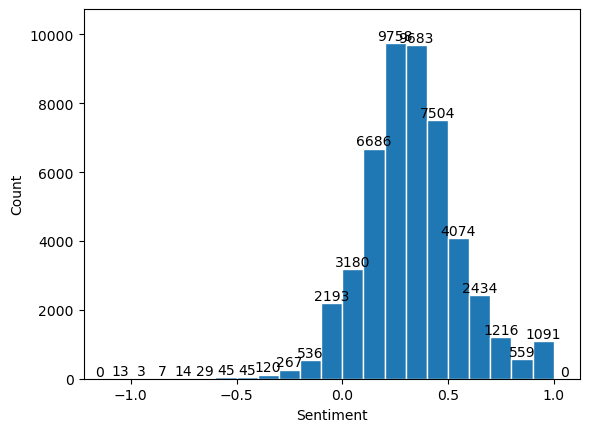

In [13]:
values, bins, bars = plt.hist(df_subset['sentiment_1'],bins=np.arange(-1.2,1.2,0.1),edgecolor='white')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.bar_label(bars, fontsize=10)
plt.margins(x=0.01, y=0.1)
plt.show()

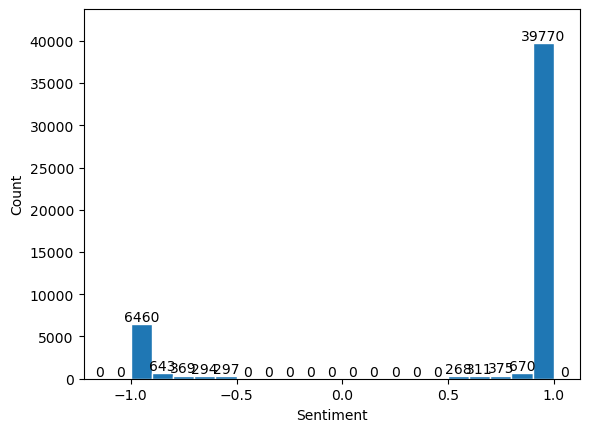

In [14]:
sent_3 = [df_subset['sentiment_3'].iloc[i][0]['score'] if df_subset['sentiment_3'].iloc[i][0]['label']=='POSITIVE' else -df_subset['sentiment_3'].iloc[i][0]['score'] for i in range(len(df_subset))]

values, bins, bars = plt.hist(sent_3,bins=np.arange(-1.2,1.2,0.1),edgecolor='white')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.bar_label(bars, fontsize=10)
plt.margins(x=0.01, y=0.1)
plt.show()

## Classification

In this section we perform a classification in order to discover patterns underlying the positive and negative ratings.

Let's keep only the results of the transformer model, along with numerical and text features.

In [15]:
df_classification = df_subset.drop(['user_id','recipe_id','date','contributor_id','submitted','nutrition','review','nostop_review','sentiment_1','sentiment_2'],axis=1)
df_classification['sentiment_score'] = sent_3
df_classification['sentiment'] = [1 if df_subset['sentiment_3'].iloc[i][0]['label']=='POSITIVE' else 0 for i in range(len(df_subset))]
df_classification.drop('sentiment_3',axis=1,inplace=True)

In [16]:
df_classification.head()

,rating,minutes,n_steps,n_ingredients,plain_review,plain_tags,plain_name,plain_description,plain_ingredients,sentiment_score,sentiment
592612,0,5,3,6,[good],"[15-minutes-or-less, time-to-make, course, cuisine, preparation, healthy, sauces, condiments-etc, asian, japanese, easy, low-fat, dietary, low-cholesterol, low-saturated-fat, low-calorie, inexpensive, low-in-something, 3-steps-or-less]","[homemade, ponzu, sauce]","[decent, substitution, real, thing]","[fresh, lime, juice, rice, vinegar, soy, sauce, mirin, light, brown, sugar, red, pepper]",1.00,1
613724,5,25,15,9,"[easy, make, &, good, never, made, brownies, box, &, worried, would, meet, brownie, cravings, did, really, easy, prepare, &, got, oven, quickly, half, butter, needed, used, unsweetened, applesauce, half, didn't, even, notice, &, think, sub, applesauce, butter, next, time, lighten, fat, &, cals, worried, overbaking, took, right, 15, mins, let, cool, bit, started, cutting, found, still, baked, enough, put, back, in, total, baked, 20mins, &, perfect, right, amount, gooey, inside]","[30-minutes-or-less, time-to-make, course, main-ingredient, preparation, desserts, oven, easy, beginner-cook, kid-friendly, cookies-and-brownies, chocolate, bar-cookies, brownies, dietary, toddler-friendly, equipment, 3-steps-or-less, baking]","[intensely, chocolate, cocoa, brownies]","[rich, brownie, mixed, sauce, pan, stove, easy, dense, soooooo, good]","[butter, cocoa, sugar, eggs, vanilla, flour, baking, powder, salt, walnuts]",-0.98,0
877117,3,60,10,11,"[ok, dropped, middle, easy, quick, fix, would, make, again, thanks]","[60-minutes-or-less, time-to-make, course, cuisine, preparation, breads, coffee-cakes, south-american, chilean]","[que, que, chilean, coffee, cake]","[low, dense, coffee, cake, hint, citrus, recommend, using, lemon, extract, vs, vanilla, called, recipe, cake, tends, fall, center, posters, mentioned, tried, baking, 9x9, pan, helped, still, sank, little, anyone, suggestions, love, hear, really, delicious, coffee, cake, --brenda]","[sugar, unsalted, butter, egg, flour, baking, powder, baking, soda, buttermilk, lemon, rind, vanilla, extract, pecans, ""confectioners, sugar""]",1.00,1
366684,4,70,16,14,"[awesome, first, time, made, following, recipe, letter, liked, it, admittedly, little, dry, next, time, save, time, used, jar, ragu, instead, sauce, recipe, cut, back, spinach, 6, oz, added, extra, cup, cheese, came, even, better]","[time-to-make, course, main-ingredient, preparation, main-dish, pasta, vegetables, oven, vegetarian, lasagna, dietary, low-calorie, mushrooms, low-in-something, pasta-rice-and-grains, equipment, 4-hours-or-less]","[portabella, mushroom, spinach, feta, lasagna, vegetarian]","[wonderful, vegetarian, dish, desired, regular, mushrooms, may, substituted, portabellos, regular, mushrooms, sautéed, first, release, moisture, make, things, easier, may, classico, pasta, sauce, recipe, use, favorite, sauce, ---, prep, time, includes, boiling, pasta]","[lasagna, noodles, diced, tomatoes, with, juice, tomato, sauce, tomato, paste, balsamic, vinegar, dried, basil, dried, oregano, garlic, powder, salt, and, pepper, mozzarella, cheese, feta, cheese, frozen, chopped, spinach, egg, portabella, mushroom]",1.00,1
469583,5,70,10,4,"[great, -, like, remember, tasting, bake, little, longer, get, totally, dry, also, seem, remember, putting, peppermint, oil/extract, x-mas, timemay, try, next, anyway, great]","[time-to-make, course, main-ingredient, preparation, occasion, for-large-groups, healthy, 5-ingredients-or-less, desserts, eggs-dairy, easy, dinner-party, holiday-event, low-fat, cookies-and-brownies, eggs, dietary, low-sodium, low-cholesterol, low-saturated-fat, low-in-something, brunch, taste-mood, sweet, number-of-servings, 4-hours-or-less]","[easy, delicious, meringue, cookies]","[sweet, satisfying, snack, dessertand, low, caloire, too, step, mom, brought, family, dinner, hit]","[egg, whites, vanilla, extract, cream, of, tartar, sugar]",0.98,1


In order to perform a classification, we need to make a one-hot-encoding of the text features by counting the frequencies of various words in one of the text columns and keeping only the most frequent ones. Since the dataset is heavily biased towards positive reviews, we differentiate between the most frequent words in both positive and negative reviews. Moreover, since many frequent words are in common between the two classes, in choosing the words for the negative class we drop those that are common also in the positive class.

In [17]:
def most_frequent(df_classification,words_to_ignore=None):

    review_words_list = []
    tags_words_list = []
    name_words_list = []
    description_words_list = []
    ingredients_words_list = []

    for id, elem in df_classification.iterrows():
        review_words_list += elem.plain_review
        tags_words_list += elem.plain_tags
        name_words_list += elem.plain_name
        description_words_list += elem.plain_description
        ingredients_words_list += elem.plain_ingredients

    review_words = dict(zip(Counter(review_words_list).keys(), Counter(review_words_list).values()))
    tags_words = dict(zip(Counter(tags_words_list).keys(), Counter(tags_words_list).values()))
    name_words = dict(zip(Counter(name_words_list).keys(), Counter(name_words_list).values()))
    description_words = dict(zip(Counter(description_words_list).keys(), Counter(description_words_list).values()))
    ingredients_words = dict(zip(Counter(ingredients_words_list).keys(), Counter(ingredients_words_list).values()))

    dicts = [review_words,tags_words,name_words,description_words,ingredients_words]

    if words_to_ignore is not None:
        for k in words_to_ignore:
            for d in dicts:
                d.pop(k, None)

    review_words_sorted = dict(sorted(review_words.items(), key=lambda item: item[1],reverse=True))
    tags_words_sorted = dict(sorted(tags_words.items(), key=lambda item: item[1],reverse=True))
    name_words_sorted = dict(sorted(name_words.items(), key=lambda item: item[1],reverse=True))
    description_words_sorted = dict(sorted(description_words.items(), key=lambda item: item[1],reverse=True))
    ingredients_words_sorted = dict(sorted(ingredients_words.items(), key=lambda item: item[1],reverse=True))

    return review_words_sorted,tags_words_sorted,name_words_sorted,description_words_sorted,ingredients_words_sorted

In [18]:
df_classification_positive = df_classification.loc[df_classification.sentiment==1]
pos_review_words_sorted,pos_tags_words_sorted,pos_name_words_sorted,pos_description_words_sorted,pos_ingredients_words_sorted = most_frequent(df_classification_positive)

In [19]:
dict(itertools.islice(pos_review_words_sorted.items(), 10))

{'recipe': 23783,
 'made': 17586,
 'used': 15062,
 'thanks': 13685,
 'make': 12295,
 'great': 12027,
 'good': 11025,
 'easy': 8650,
 'it': 7423,
 'added': 7315}

In [20]:
df_classification_negative = df_classification.loc[df_classification.sentiment==0]
words_to_ignore = list(dict(itertools.islice(pos_review_words_sorted.items(), 20)).keys())
neg_review_words_sorted,neg_tags_words_sorted,neg_name_words_sorted,neg_description_words_sorted,neg_ingredients_words_sorted = most_frequent(df_classification_negative,words_to_ignore)

In [21]:
dict(itertools.islice(neg_review_words_sorted.items(), 10))

{'would': 2141,
 "didn't": 1616,
 'much': 1400,
 'think': 1336,
 'next': 1312,
 'chicken': 1244,
 'add': 1213,
 'taste': 1211,
 'instead': 1169,
 'try': 1094}

Let's focus on the most frequent words in one of the text columns.

In [22]:
def prepare_dataset(df_classification,plain_col,pos_words_sorted,neg_words_sorted,n):
    '''
    Computes a one-hot encoding based on the occurrences of the first n words
    in the plain_col text column.

    Inputs:
        df_classification: the preprocessed dataset containing the sentiment analysis results
        plain_col: the text column chosen to perform the classification
        words_sorted: the dictionary containing the words frequencies in the plain_col column,
            sorted by descending frequency
        n: the number of most frequent words to consider for the encoding
    Outputs:
        df: the classification-ready dataframe, containing the target column 'sentiment' and
            the one-hot encoded features
    '''

    # keep only the top n elements
    pos_most_frequent = dict(itertools.islice(pos_words_sorted.items(), round(n/2)))
    neg_most_frequent = dict(itertools.islice(neg_words_sorted.items(), round(n/2)))
    most_frequent = dict(list(pos_most_frequent.items()) + list(neg_most_frequent.items()))

    # drop all columns except the sentiment, minutes, n_steps and n_ingredients ones and the selected text column
    l = df_classification.columns.tolist()
    l.remove(plain_col)
    l.remove('sentiment')
    l.remove('minutes')
    l.remove('n_steps')			
    l.remove('n_ingredients')
    df = df_classification.reset_index().drop(l,axis=1)

    freq = dict()
    df_freq = pd.DataFrame()

    # iterate over the dataframe rows and make a dataframe that
    # contains a 1 [0] for the most frequent words that are [not] 
    # contained in the selected text column
    for id, elem in df.iterrows():
        for k in most_frequent.keys():
            f = list(set(elem[plain_col])).count(k)
            freq[k] = f
        df_freq = df_freq.append([freq],ignore_index=True)

    df.drop(plain_col,axis=1,inplace=True)
    # merge the frequencies dataframe with the one containing
    # the sentiment column
    df = pd.merge(df,df_freq,left_index=True, right_index=True)

    return df

In [23]:
df = prepare_dataset(df_classification,'plain_review',pos_review_words_sorted,neg_review_words_sorted,20).drop('index',axis=1)
df.head()

,minutes,n_steps,n_ingredients,sentiment,recipe,made,used,thanks,make,great,...,would,didn't,much,think,next,chicken,add,taste,instead,try
0,5,3,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25,15,9,0,0,1,1,0,1,0,...,1,1,0,1,1,0,0,0,0,0
2,60,10,11,1,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
3,70,16,14,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,70,10,4,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


In [24]:
df.describe()

,minutes,n_steps,n_ingredients,sentiment,recipe,made,used,thanks,make,great,...,would,didn't,much,think,next,chicken,add,taste,instead,try
count,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,...,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00,49457.00
mean,66.11,9.59,8.95,0.84,0.43,0.34,0.30,0.30,0.26,0.24,...,0.12,0.10,0.11,0.08,0.10,0.08,0.09,0.08,0.09,0.07
std,93.79,5.78,3.67,0.37,0.49,0.47,0.46,0.46,0.44,0.42,...,0.32,0.30,0.31,0.27,0.30,0.27,0.29,0.28,0.29,0.26
min,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,20.00,6.00,6.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,40.00,8.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,65.00,12.00,11.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,750.00,97.00,43.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Let's train a random forest classifier on this dataset.

In [25]:
X = df.drop('sentiment',axis=1)
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Before fitting the classifier, let's compute how many occurrences of positive (1) and negative (0) sentiments are present in the whole, training and testing datasets, in order to check that the two classes are not too heavily imbalanced.

In [26]:
def print_n_samples(df,y_train,y_test):
    n_tot = df.sentiment.count()
    n_train = y_train.count()
    n_test = y_test.count()

    print('- Number of samples per class: total, train, test -')
    for sent in df.sentiment.unique():

        tot_class = df.sentiment.loc[df.sentiment==sent].count()
        tot_class_perc = np.round(tot_class/n_tot,3)*100

        train_class = y_train.loc[y_train==sent].count()
        train_class_perc = np.round(train_class/n_train,3)*100

        test_class = y_test.loc[y_test==sent].count()
        test_class_perc = np.round(test_class/n_test,3)*100

        print('Class {}: {}({}%) {}({}%) {}({}%)'.format(sent,tot_class,tot_class_perc,train_class,train_class_perc,test_class,test_class_perc))

    return

print_n_samples(df,y_train,y_test)

- Number of samples per class: total, train, test -
Class 1: 41394(83.7%) 33131(83.7%) 8263(83.5%)
Class 0: 8063(16.3%) 6434(16.3%) 1629(16.5%)


In [27]:
forest = RandomForestClassifier(random_state=42)
forest = forest.fit(X_train, y_train)

Let's print some scores and display the precision-recall and ROC curves along with the confusion matrix, in order to understand the performance of the model.

In [28]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,PrecisionRecallDisplay,RocCurveDisplay,confusion_matrix,ConfusionMatrixDisplay

def print_scores(classifier,X_train,X_test,y_train,y_test):

    y_true = y_train
    y_pred = classifier.predict(X_train)
    train_acc = accuracy_score(y_true,y_pred)
    train_pre = precision_score(y_true,y_pred)
    train_rec = recall_score(y_true,y_pred)
    print('- Training set scores -')
    print('Accuracy: {}'.format(train_acc))
    print('Precision: {}'.format(train_pre))
    print('Recall: {}'.format(train_rec))

    y_true = y_test
    y_pred = classifier.predict(X_test)
    test_acc = accuracy_score(y_true,y_pred)
    test_pre = precision_score(y_true,y_pred)
    test_rec = recall_score(y_true,y_pred)
    print('\n- Test set scores -')
    print('Accuracy: {}'.format(test_acc))
    print('Precision: {}'.format(test_pre))
    print('Recall: {}'.format(test_rec))

    display = PrecisionRecallDisplay.from_estimator(classifier,X_test,y_test,name="forest")
    _ = display.ax_.set_title("Precision-Recall curve")

    display = RocCurveDisplay.from_estimator(classifier,X_test,y_test,name="forest")
    _ = display.ax_.set_title("ROC curve")

    predictions = classifier.predict(X_test)
    cm = confusion_matrix(y_test,predictions,labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
    disp.plot()

    plt.show()
    return

- Training set scores -
Accuracy: 0.9929230380386705
Precision: 0.9933323321820093
Recall: 0.998249373698349

- Test set scores -
Accuracy: 0.8215729882733522
Precision: 0.8414249684741488
Recall: 0.9690185162773811


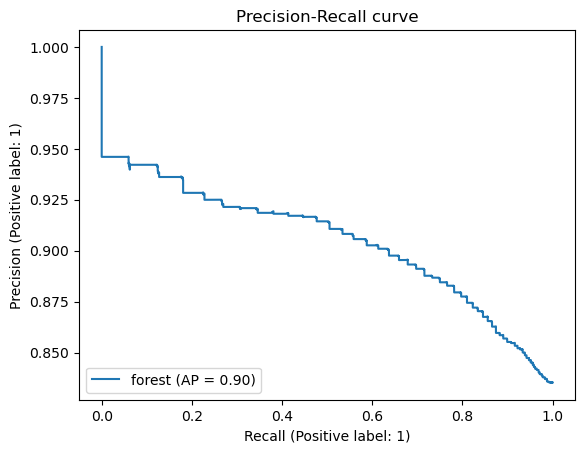

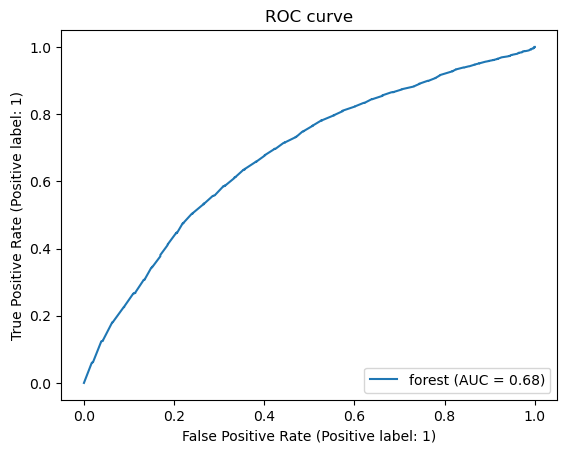

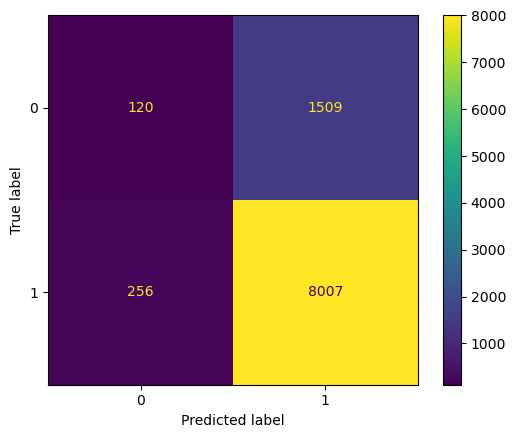

In [29]:
print_scores(forest,X_train,X_test,y_train,y_test)

As we see, the model is slightly better than a completely random classifier, since its accuracy on the test set is similar to the fraction of positive samples in the dataset. Moreover, most negative examples are classified as positive. In order to try to construct a better model, we can stratify the dataset in order to make it balanced. This is done by undersampling the majority class, i.e. the positive one. 

In [30]:
df_strat = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), 8000),random_state=42))

In [31]:
X_strat = df_strat.drop('sentiment',axis=1)
y_strat = df_strat.sentiment

X_strat_train, X_strat_test, y_strat_train, y_strat_test = train_test_split(X_strat, y_strat, test_size = 0.2)

In [32]:
print_n_samples(df_strat,y_strat_train,y_strat_test)

- Number of samples per class: total, train, test -
Class 0: 8000(50.0%) 6393(49.9%) 1607(50.2%)
Class 1: 8000(50.0%) 6407(50.1%) 1593(49.8%)


In [33]:
forest_strat = RandomForestClassifier(random_state=42)
forest_strat = forest_strat.fit(X_strat_train, y_strat_train)

- Training set scores -
Accuracy: 0.9946875
Precision: 0.9939223936418887
Recall: 0.9954737006399251

- Test set scores -
Accuracy: 0.6334375
Precision: 0.6376146788990825
Recall: 0.610797237915882


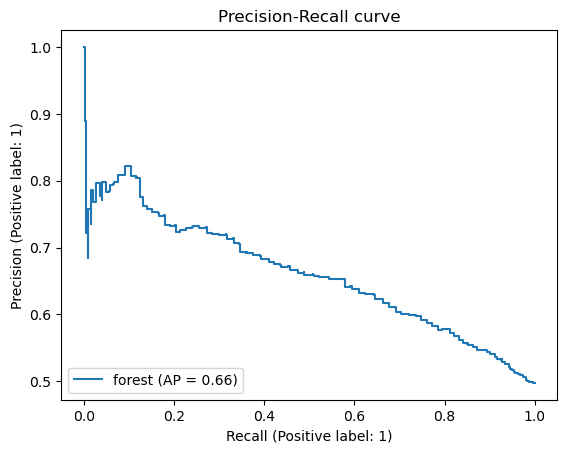

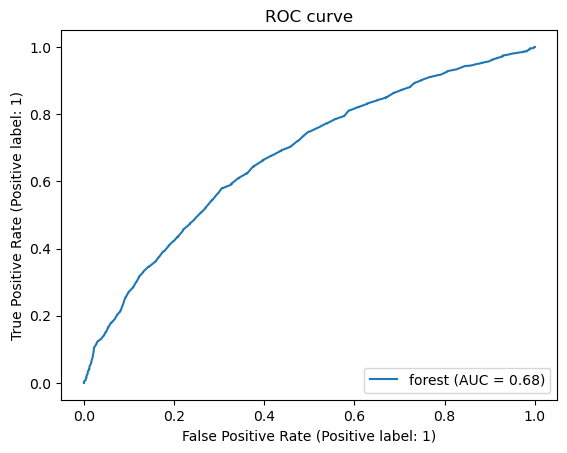

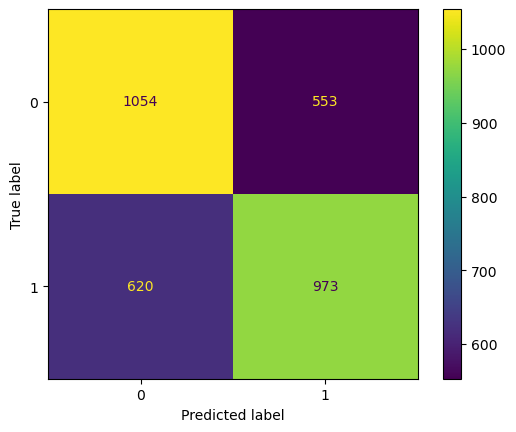

In [34]:
print_scores(forest_strat,X_strat_train,X_strat_test,y_strat_train,y_strat_test)

Judging by the difference between the training and test sets scores, the model is heavily overfitting. This is possibly because the depth of the trees in the random forest is left unrestricted. In order to improve the model, we can make use of the cross-validation technique, in order to find the best hyperparameters for the classifier.

In [49]:
param_grid = [{'max_depth': [3,5,7,9,11,13],'n_estimators': [10,50,100,200,300,400,500]}]

rfr = RandomForestClassifier(random_state=42)

rfr_cv = GridSearchCV(rfr,param_grid=param_grid,cv=5,scoring='accuracy')
clf = rfr_cv.fit(X_strat_train,y_strat_train)
best_classifier = clf.best_estimator_

In [50]:
print(best_classifier)

RandomForestClassifier(max_depth=11, n_estimators=200, random_state=42)


- Training set scores -
Accuracy: 0.746796875
Precision: 0.7891852393131166
Recall: 0.6742625253628843

- Test set scores -
Accuracy: 0.6484375
Precision: 0.6730769230769231
Recall: 0.5712492153170119


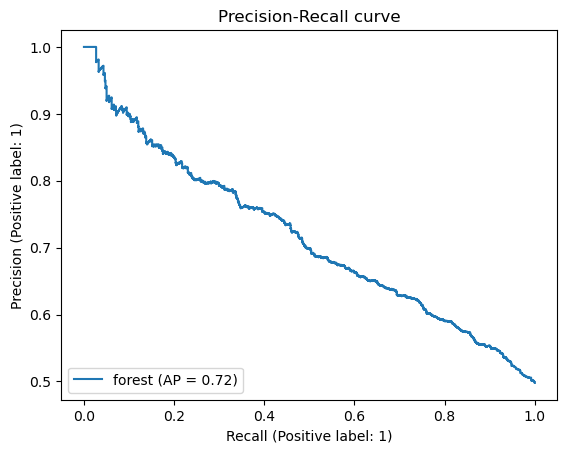

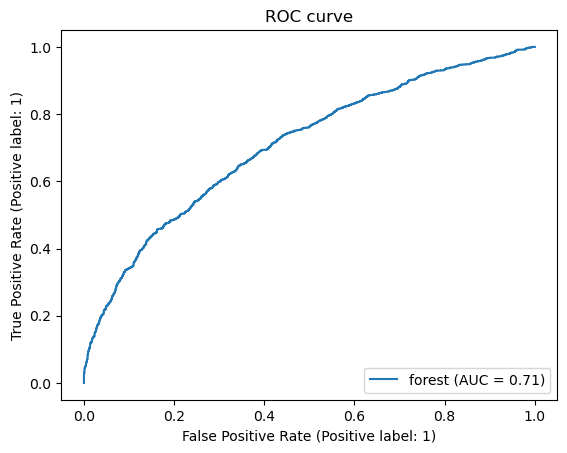

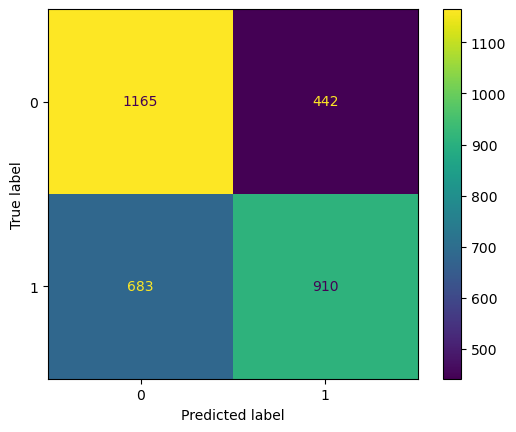

In [51]:
print_scores(best_classifier,X_strat_train,X_strat_test,y_strat_train,y_strat_test)

We can see that now the model does not suffer from heavy overfitting, and it gained some accuracy and precision, at the cost of a reduced recall. In fact, as we see from the confusion matrices, this model is more focused on correctly predicting the negative class with respect to the previous one.

## Feature importances

In this section we focus on analysing the importance of each feature in the decision of the classifier. This can be done with a variety of methods:

- Using the impurity-based attribute <code>feature_importances_</code> of the <code>RandomForestClassifier</code> method.
- Computing the permutation importance, using the package <code>eli5</code>.
- Computing the partial-dependence plots, using the package <code>pdpbox</code>.
- Computing the SHAP values, which we will not consider here.

The first method computes the importances as the mean and standard deviation of accumulation of the impurity decrease within each tree of the random forest.

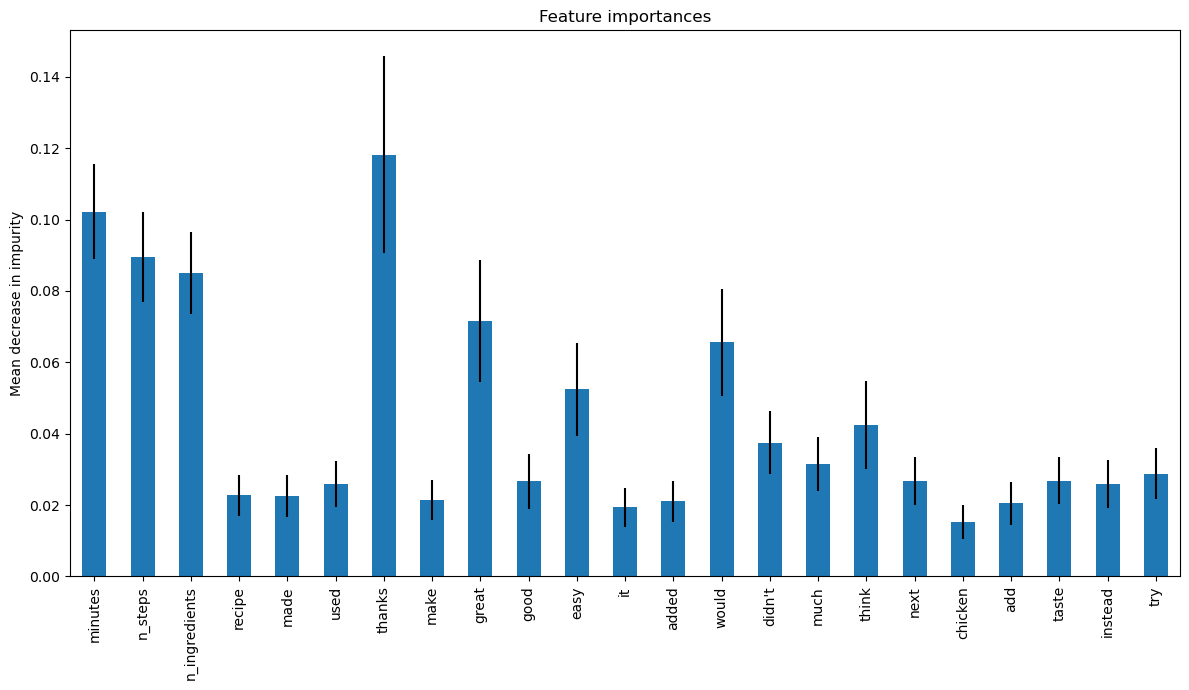

In [52]:
importances = best_classifier.feature_importances_
feature_names = X_strat_train.columns
std = np.std([tree.feature_importances_ for tree in best_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(12,7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

According to the first method, the words "thanks", "would", "great" and "easy" are the most discriminating between the two classes. Moreover, the number of minutes it takes to prepare the recipes, along with the number of steps and ingredients involved, are quite important.

The permutation importance method shows the decrease in model performance caused by shuffling each feature.

In [53]:
perm = PermutationImportance(best_classifier,random_state=42).fit(X_strat_train,y_strat_train)
exp = eli5.explain_weights(perm,feature_names=X_strat_train.columns.tolist())
exp_df = eli5.format_as_dataframe(exp)

<AxesSubplot:title={'center':'Permutation importance'}, ylabel='feature'>

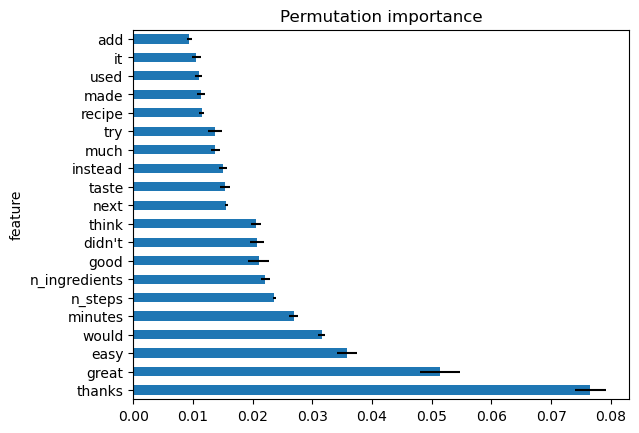

In [54]:
exp_df.plot(kind='barh',x='feature',y='weight',legend=False,title='Permutation importance',xerr ='std')

The results of this method are very similar to that of the previous one.

The last method we use is that of the partial dependence plots. In this case, the fitted model is applied to examples where the value of a single variable is altered. For example, what happens (i.e. how much does the prediction change) on average when changing the value of the variable "minutes", when keeping all the other features fixed?

In [55]:
l_pdp_rfr = []

for feat in X_strat_train.columns:
    print('Computing feature {}...'.format(feat))
    pdp_feat = pdp.pdp_isolate(model=best_classifier,dataset=X_strat_train,model_features=X_strat_train.columns,feature=feat)
    l_pdp_rfr.append(pdp_feat)

Computing feature minutes...
Computing feature n_steps...
Computing feature n_ingredients...
Computing feature recipe...
Computing feature made...
Computing feature used...
Computing feature thanks...
Computing feature make...
Computing feature great...
Computing feature good...
Computing feature easy...
Computing feature it...
Computing feature added...
Computing feature would...
Computing feature didn't...
Computing feature much...
Computing feature think...
Computing feature next...
Computing feature chicken...
Computing feature add...
Computing feature taste...
Computing feature instead...
Computing feature try...


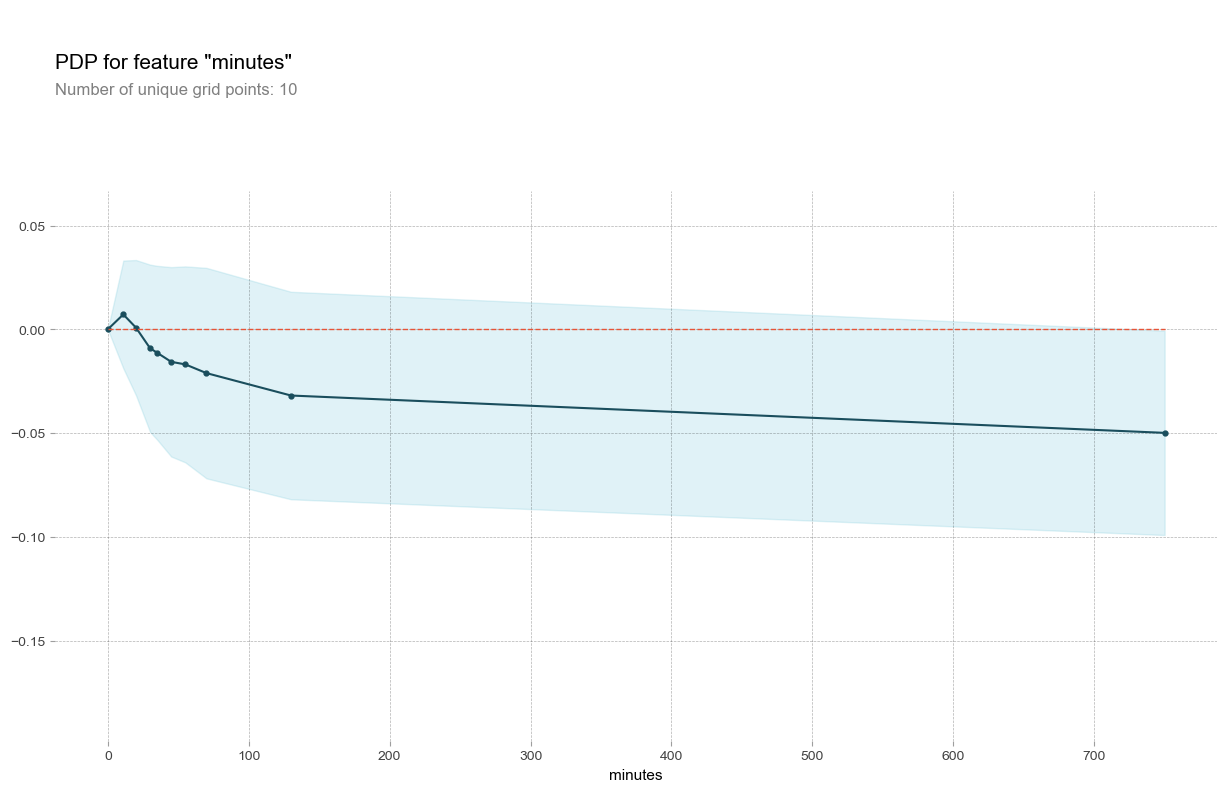

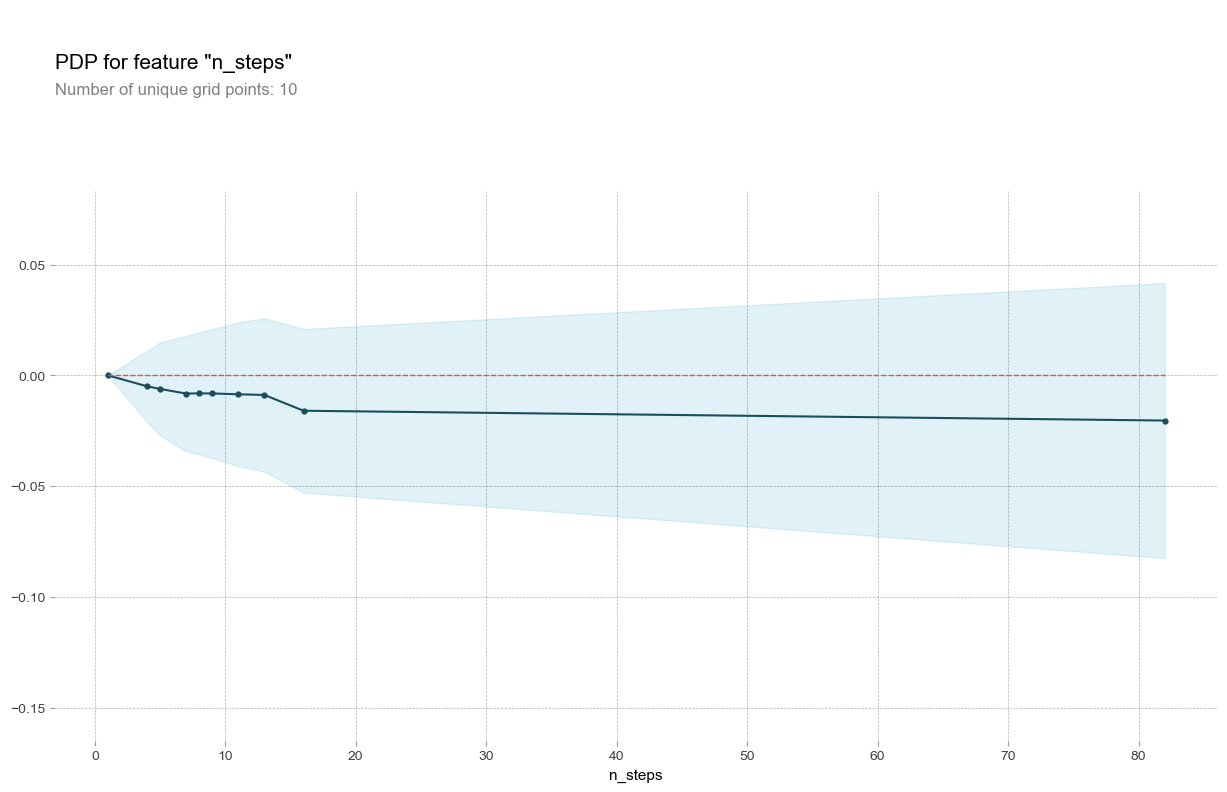

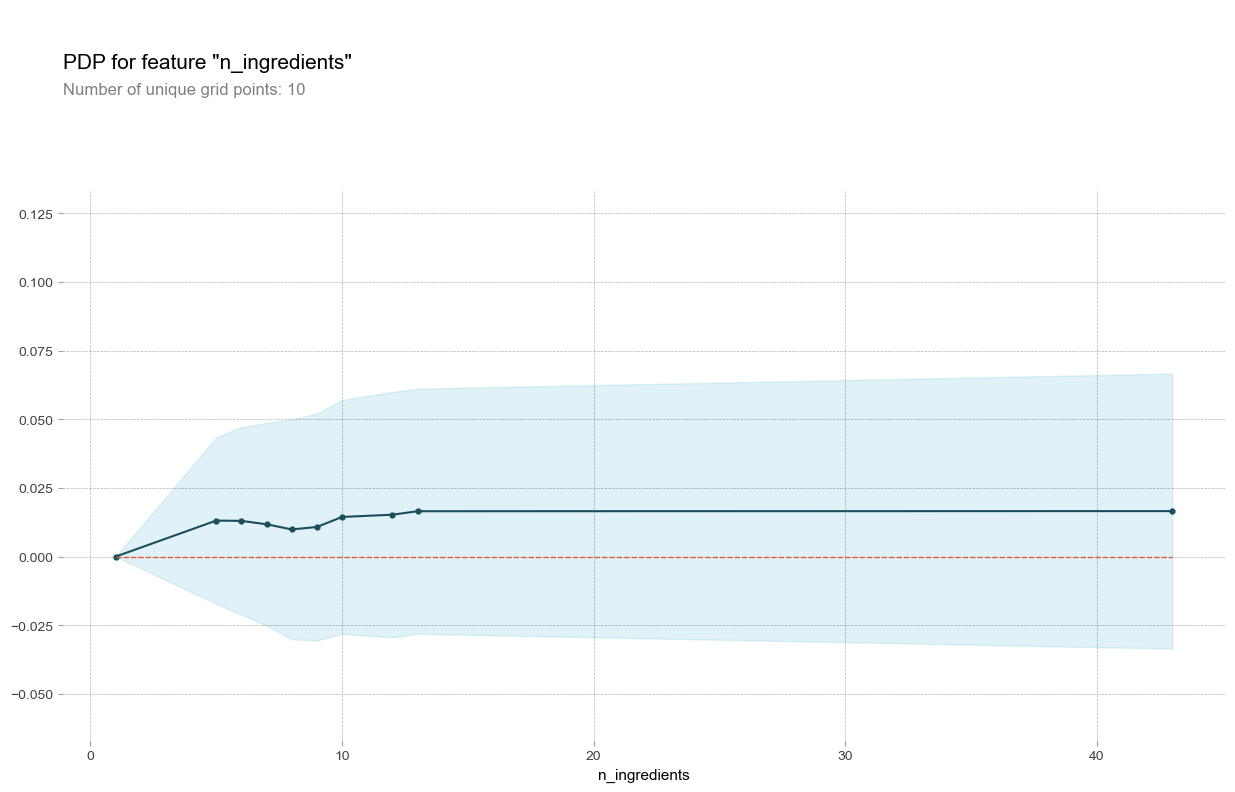

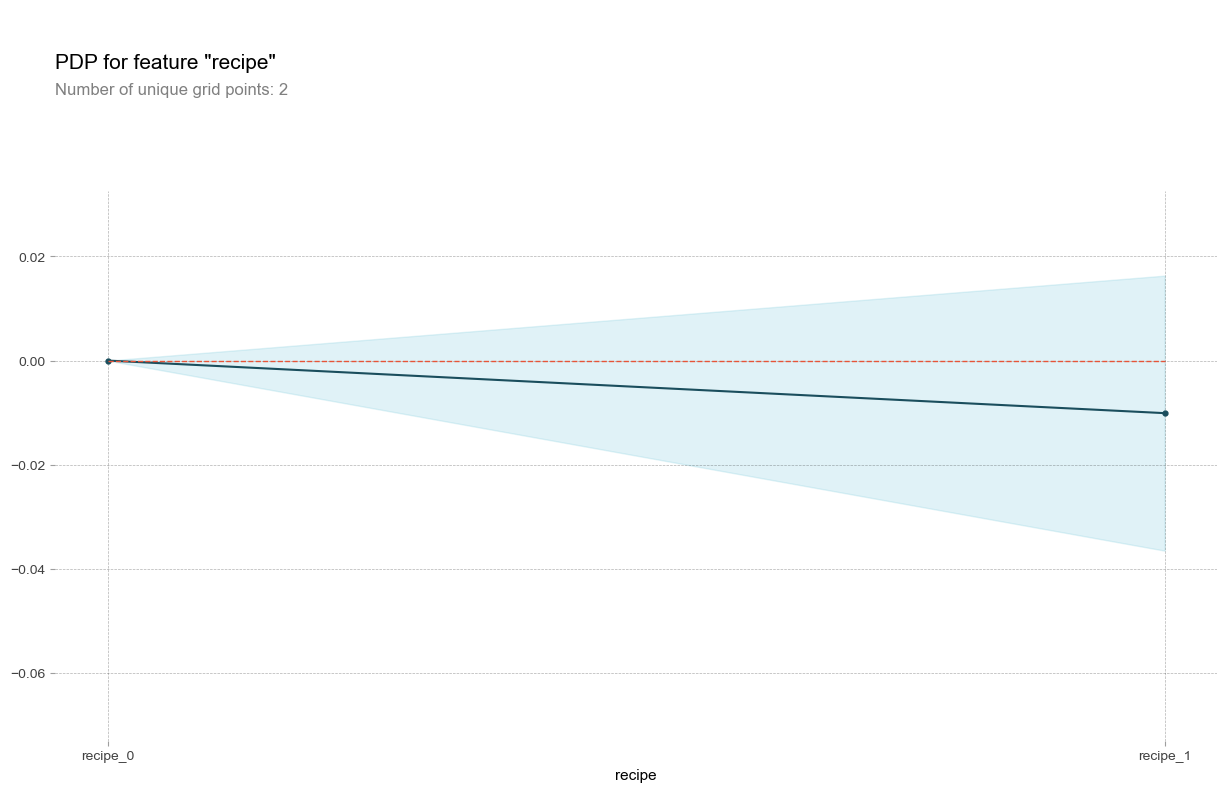

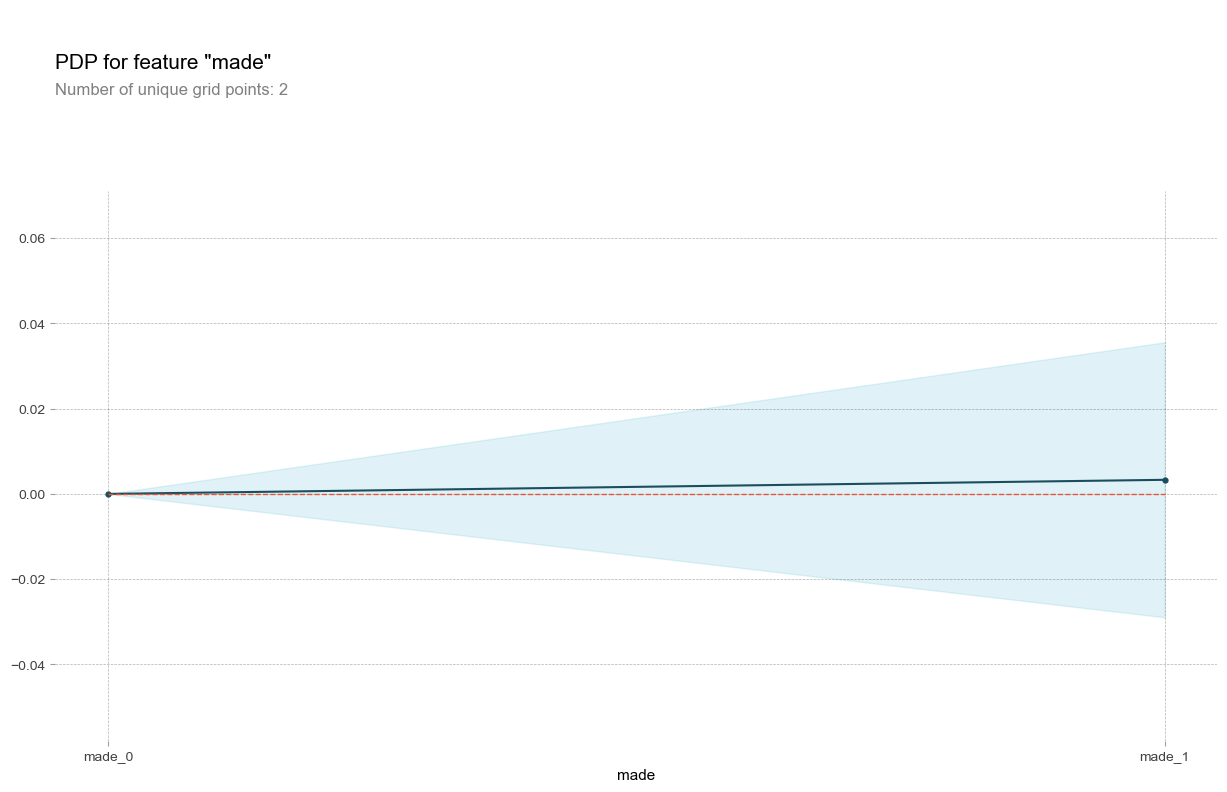

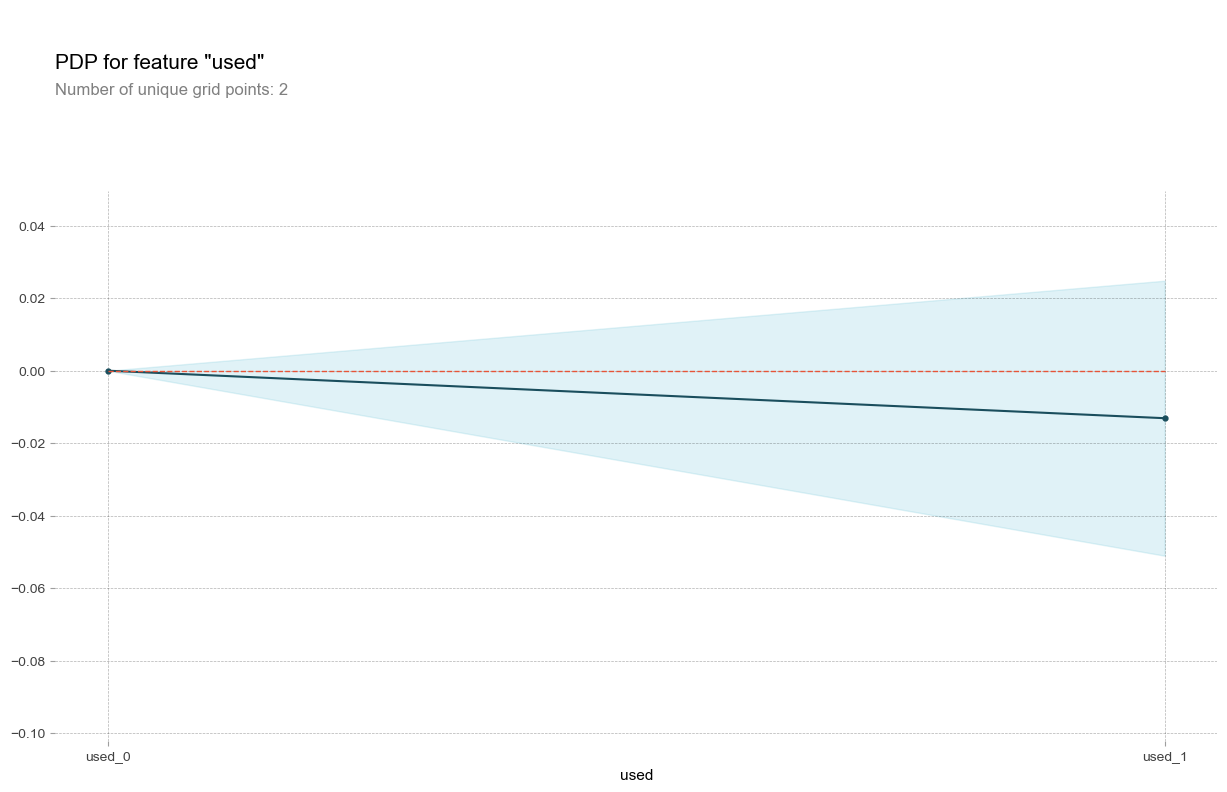

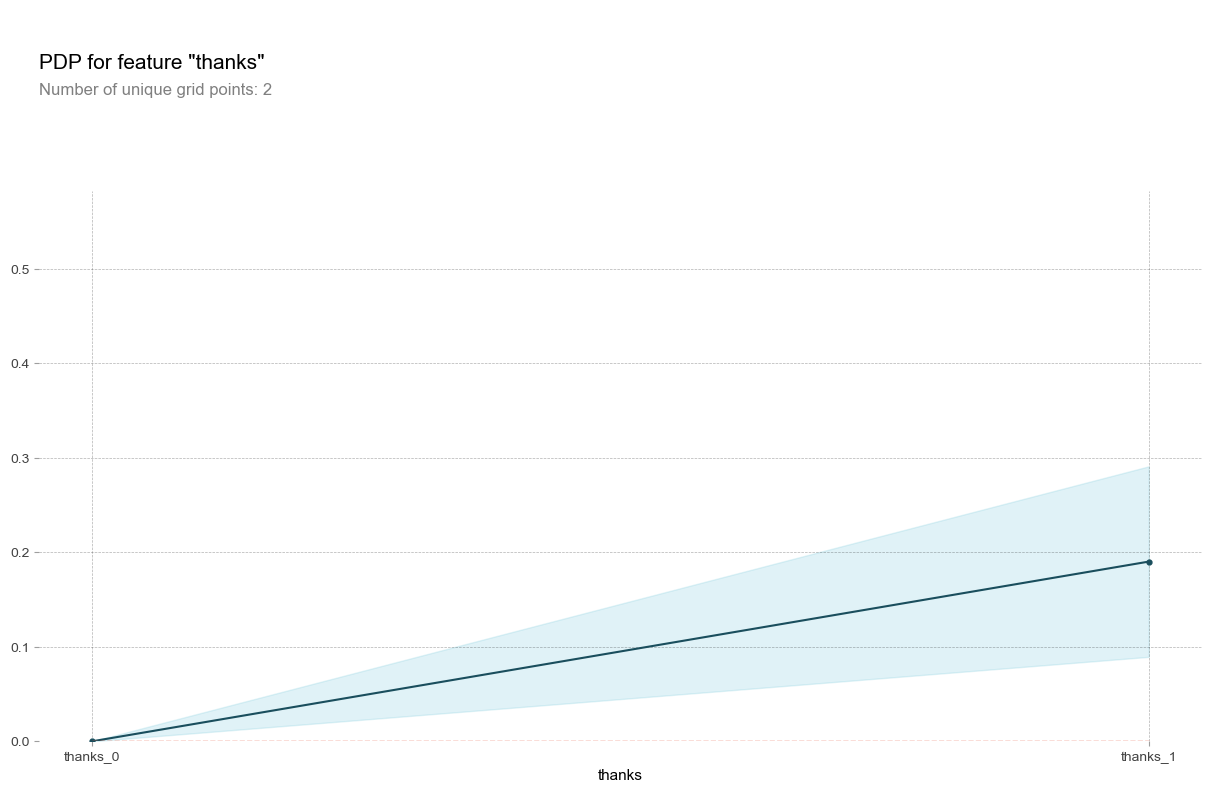

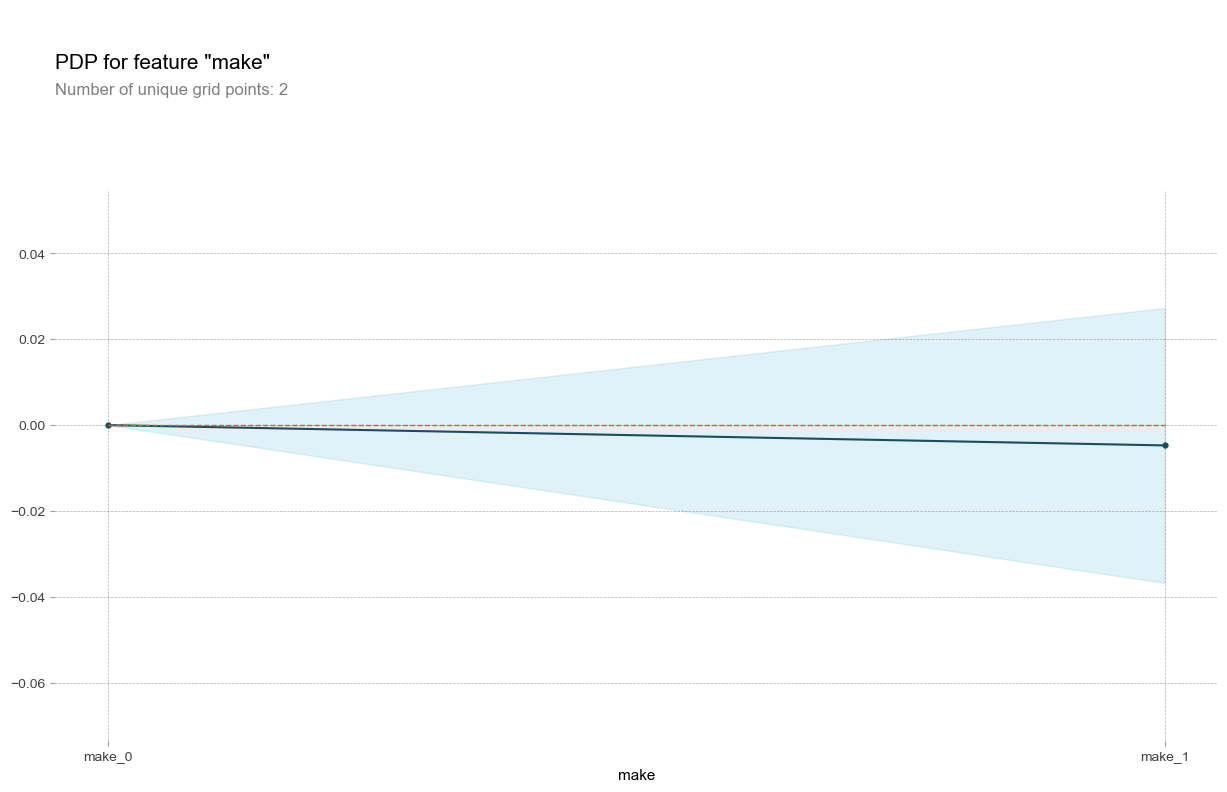

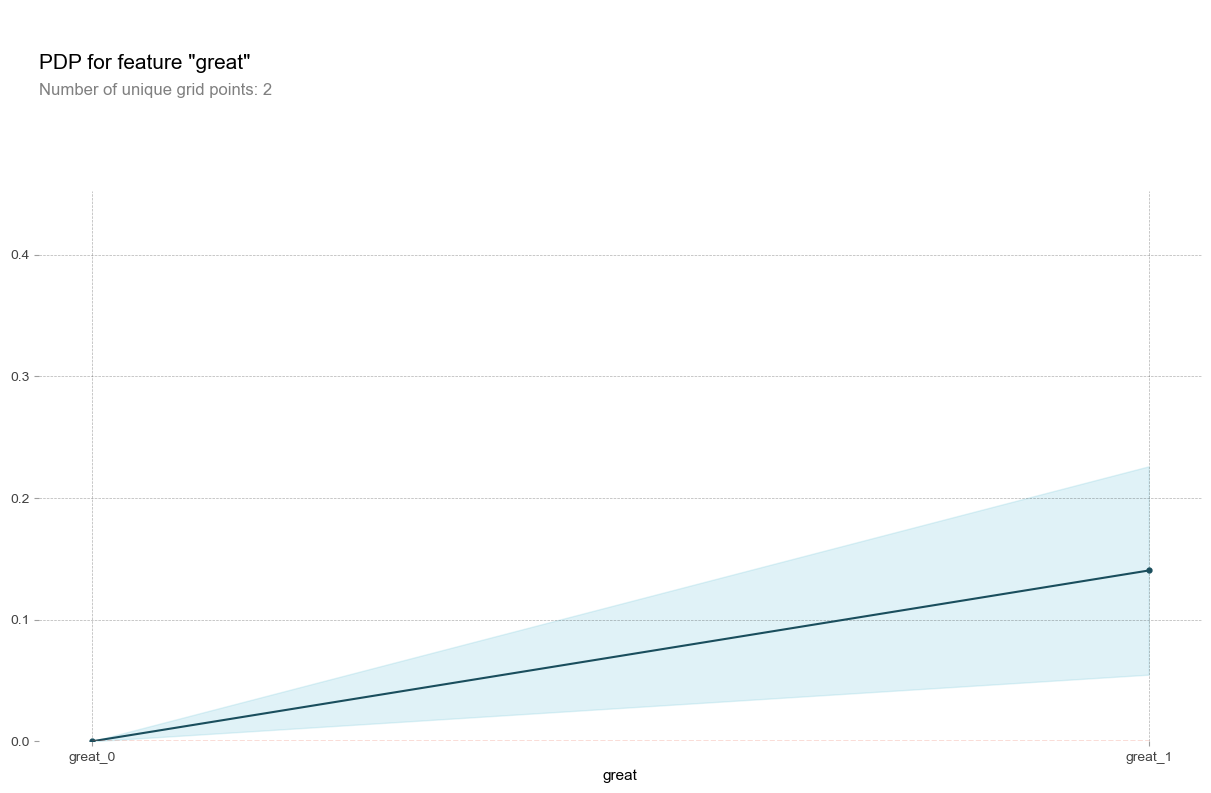

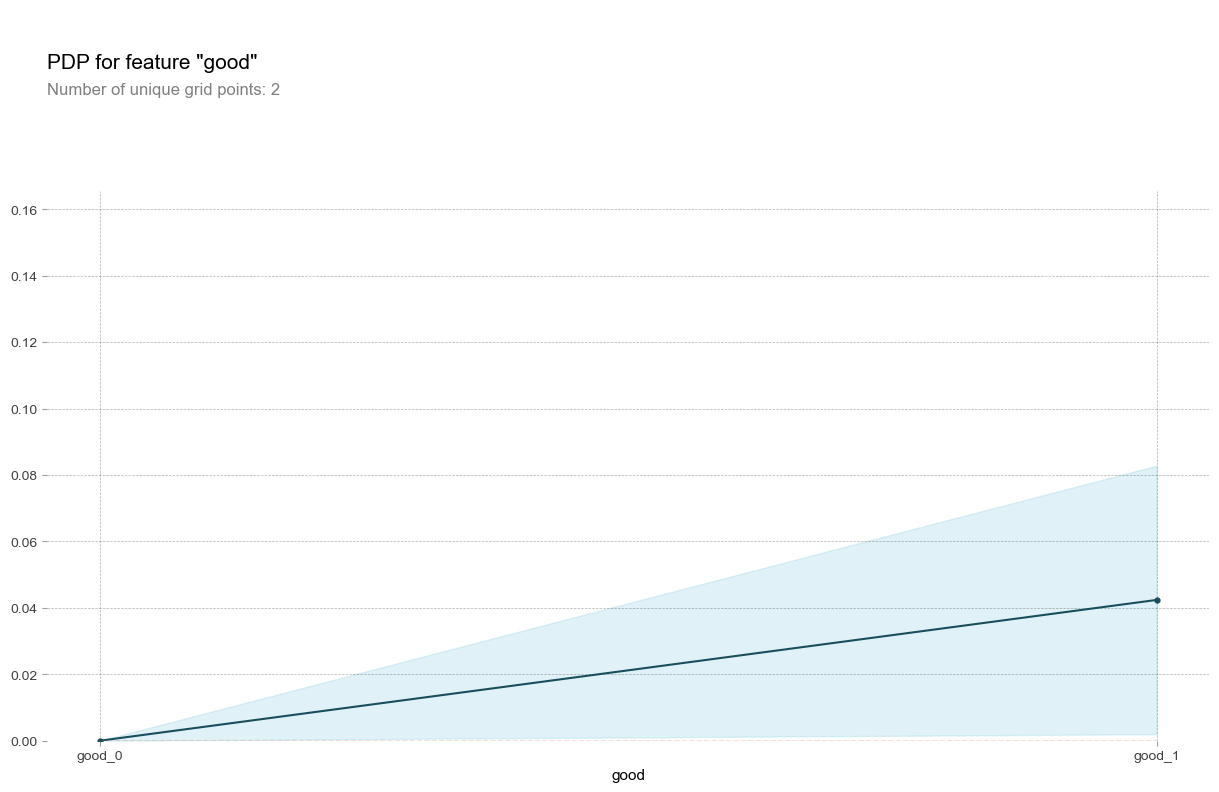

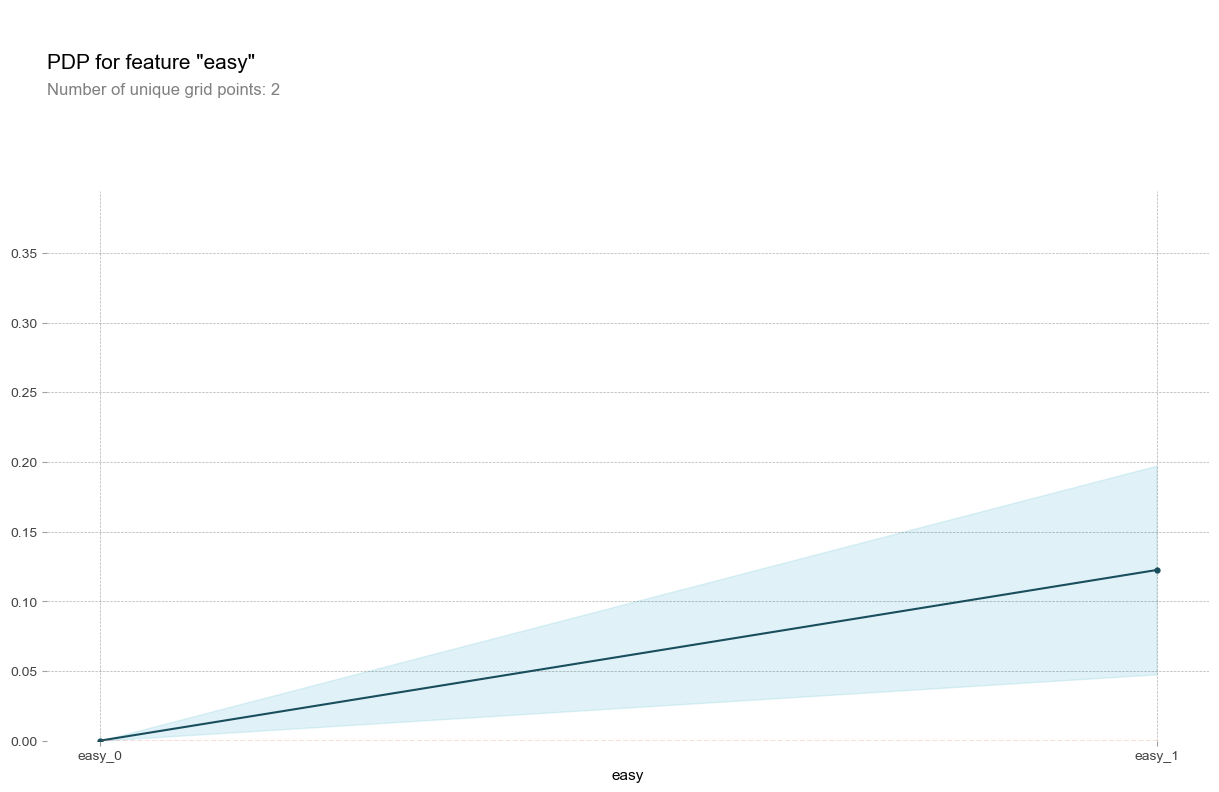

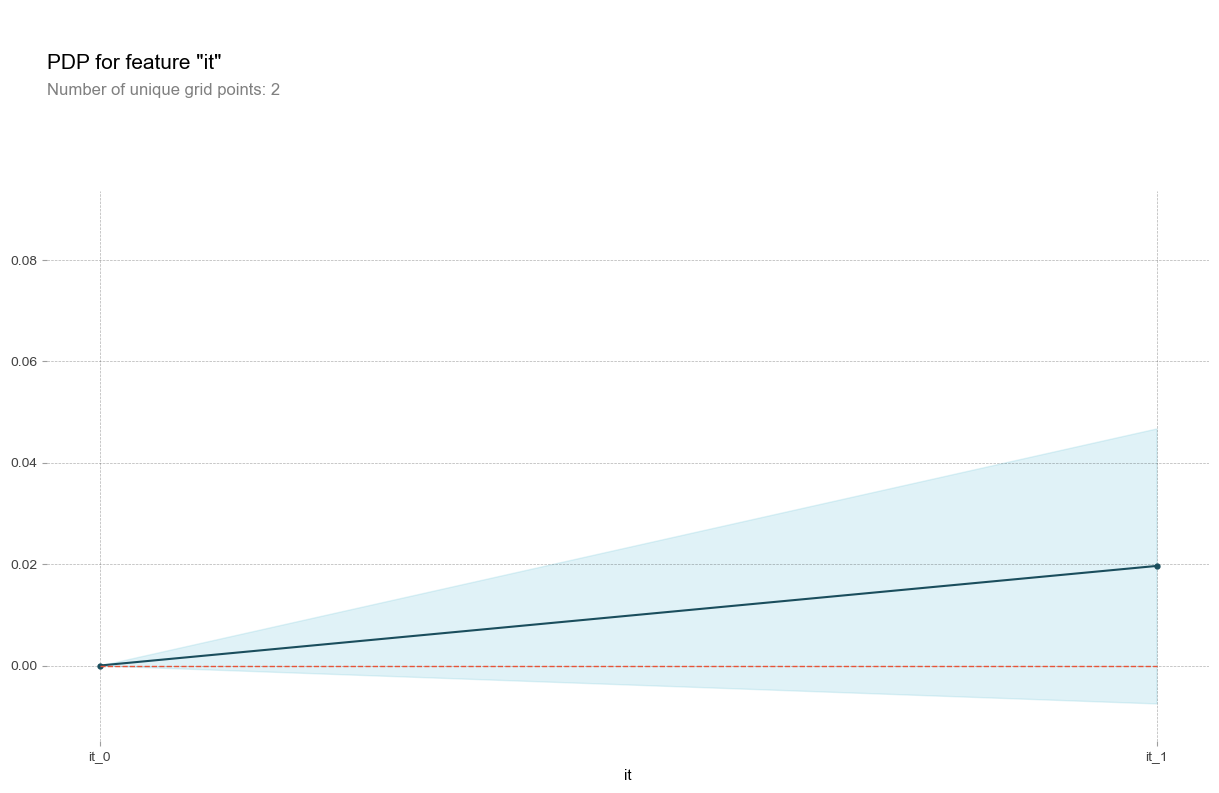

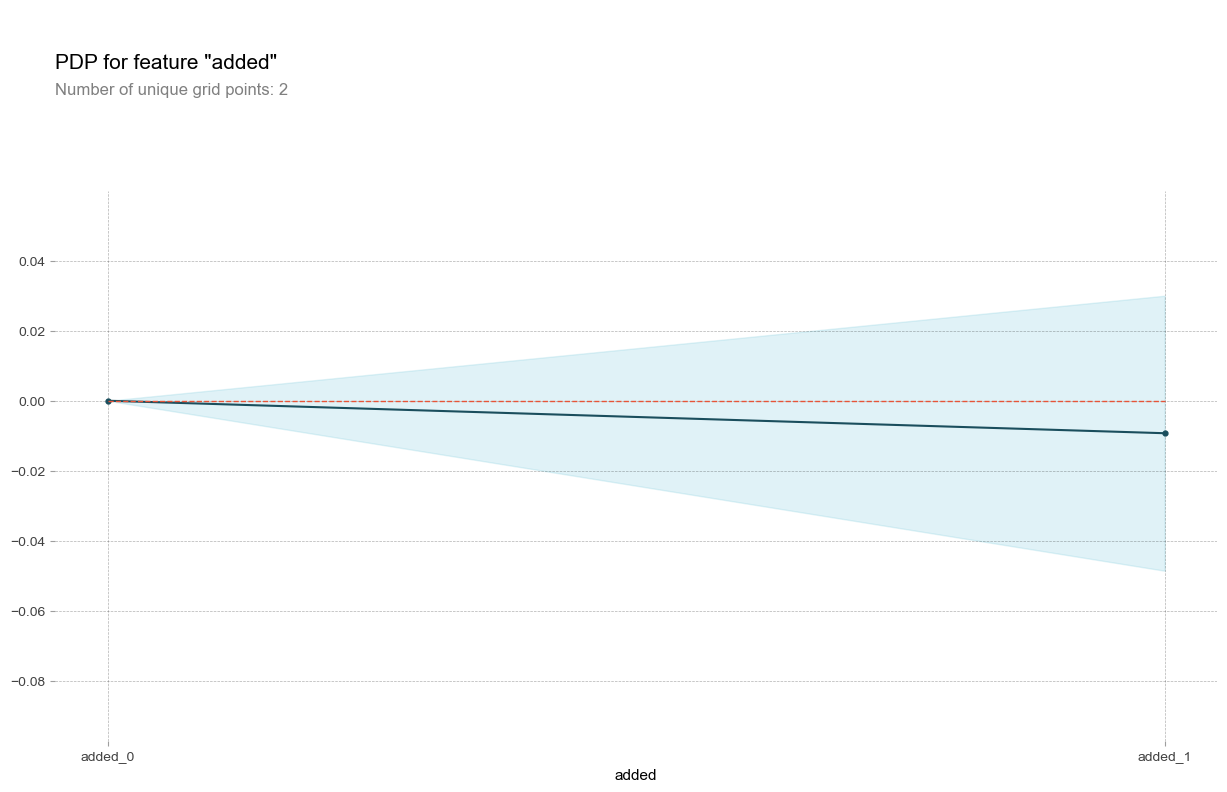

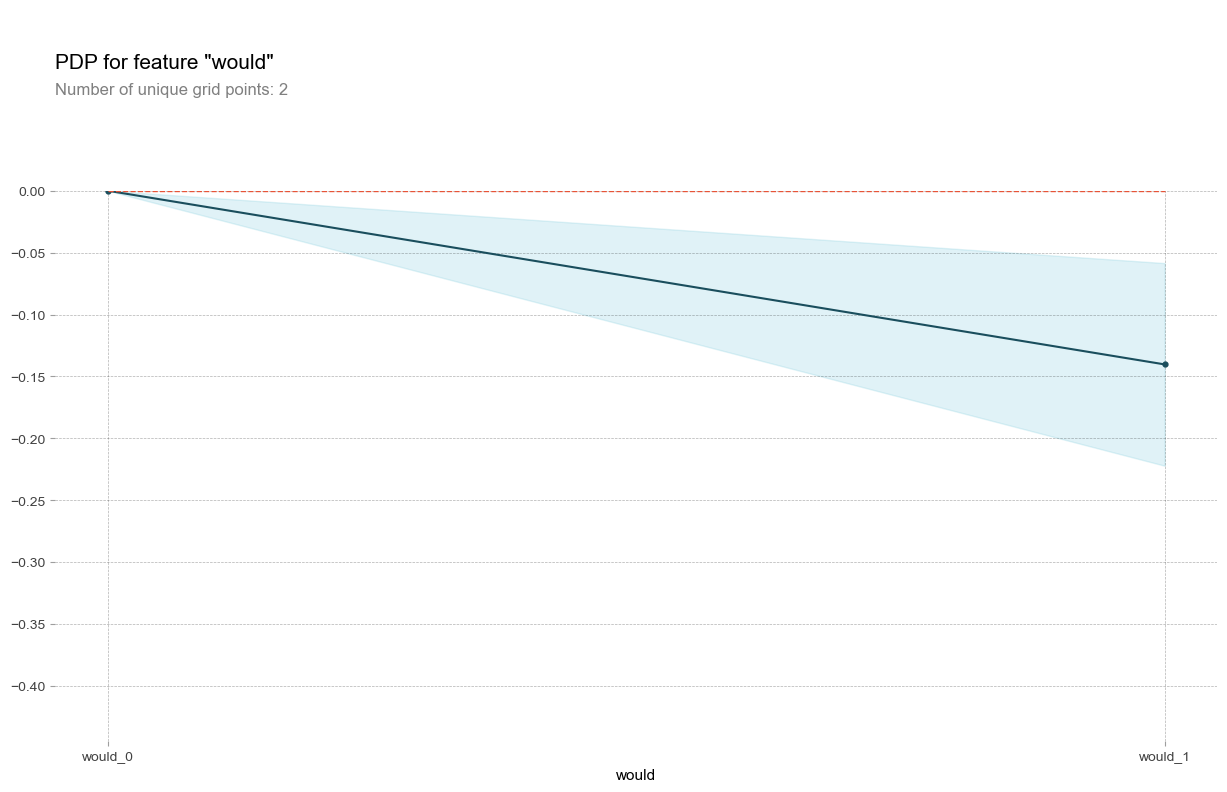

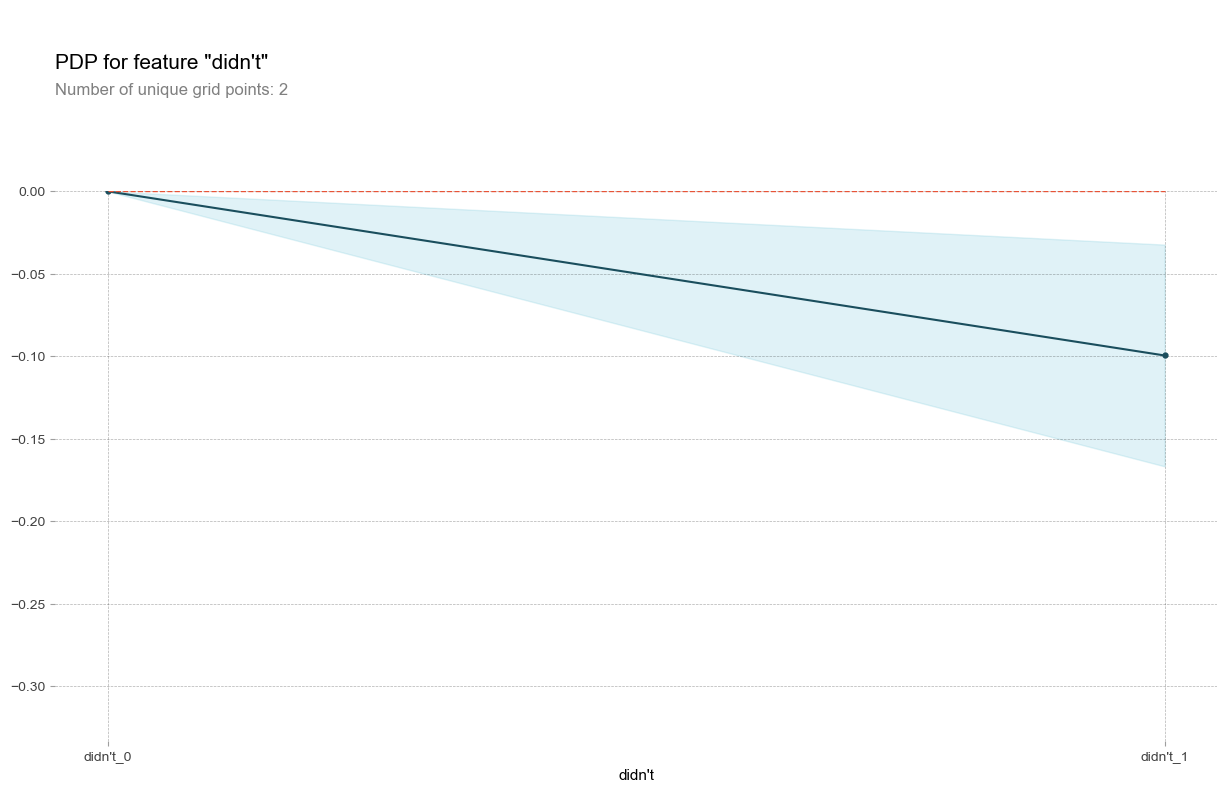

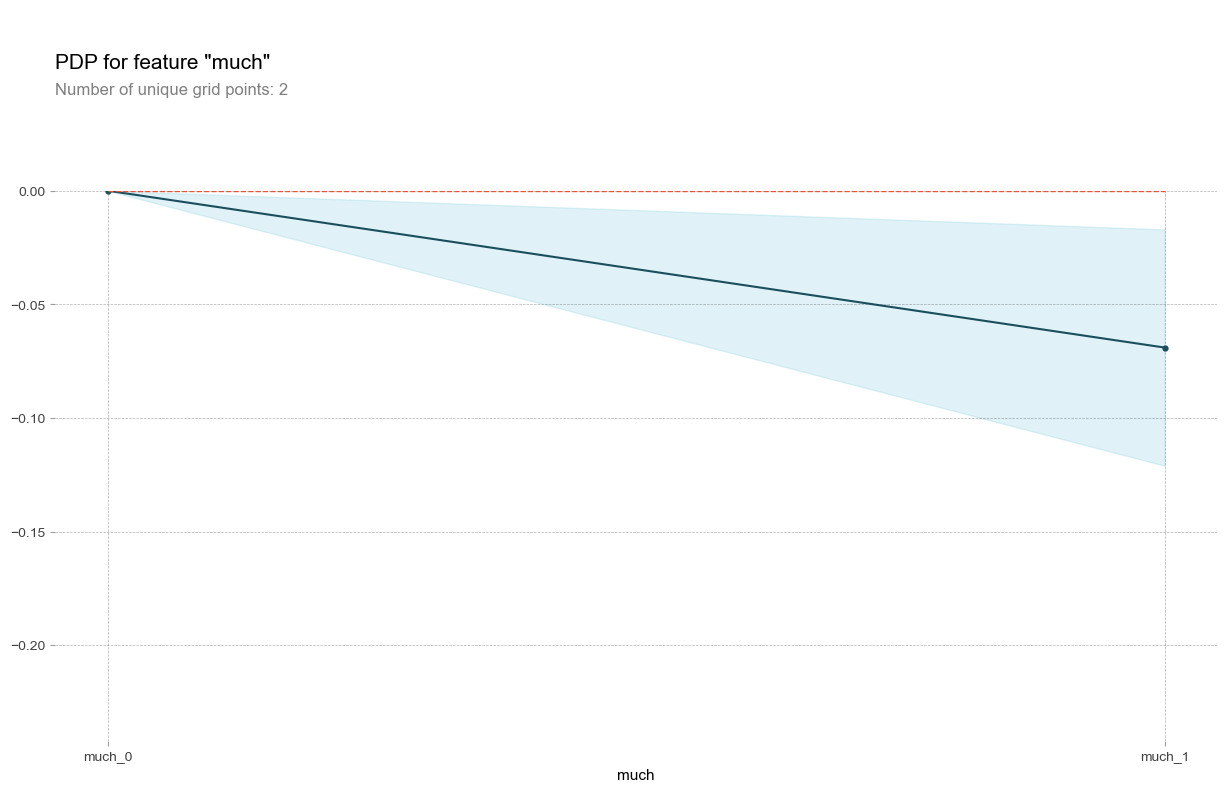

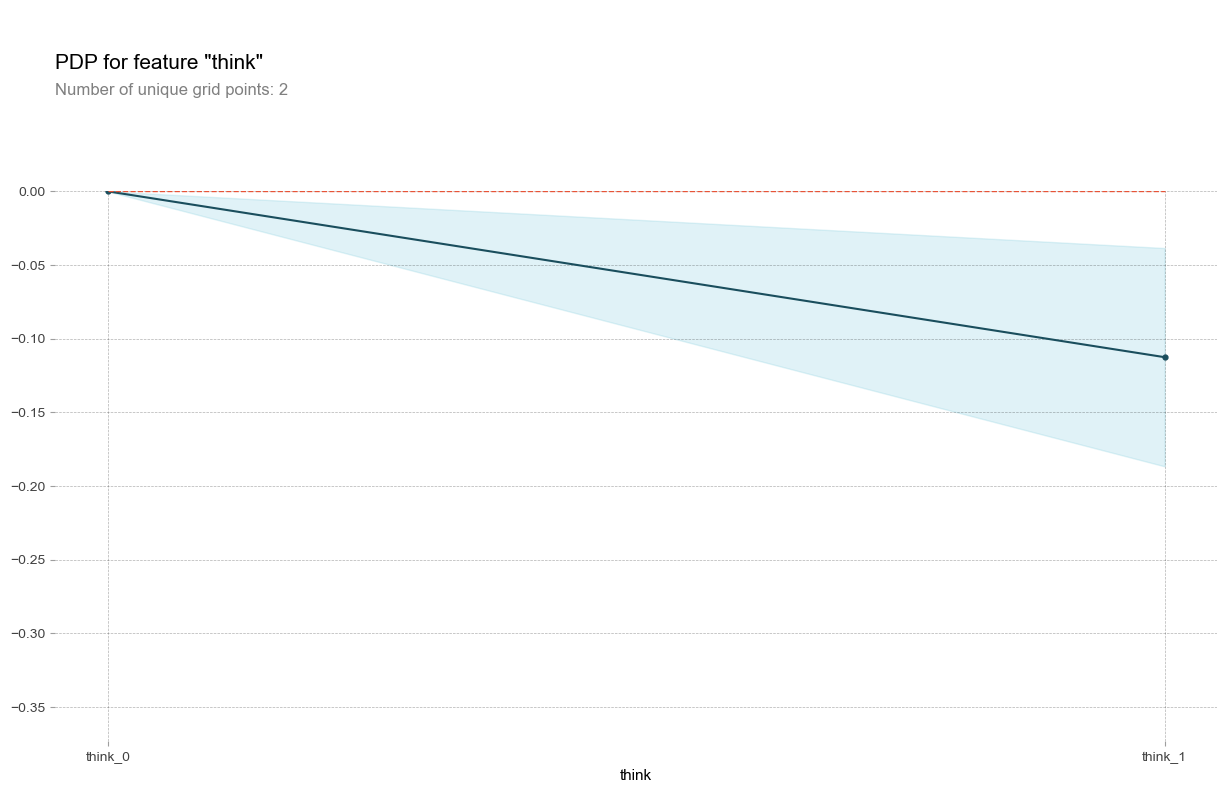

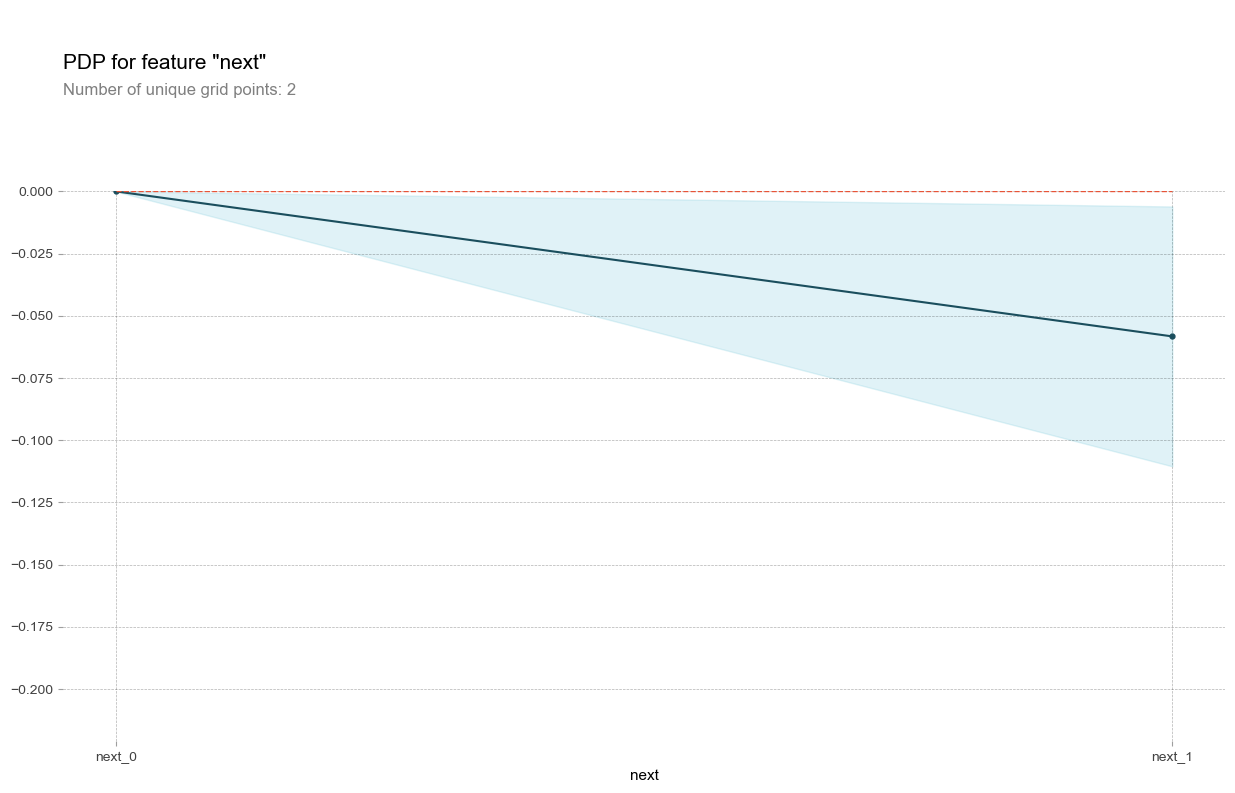

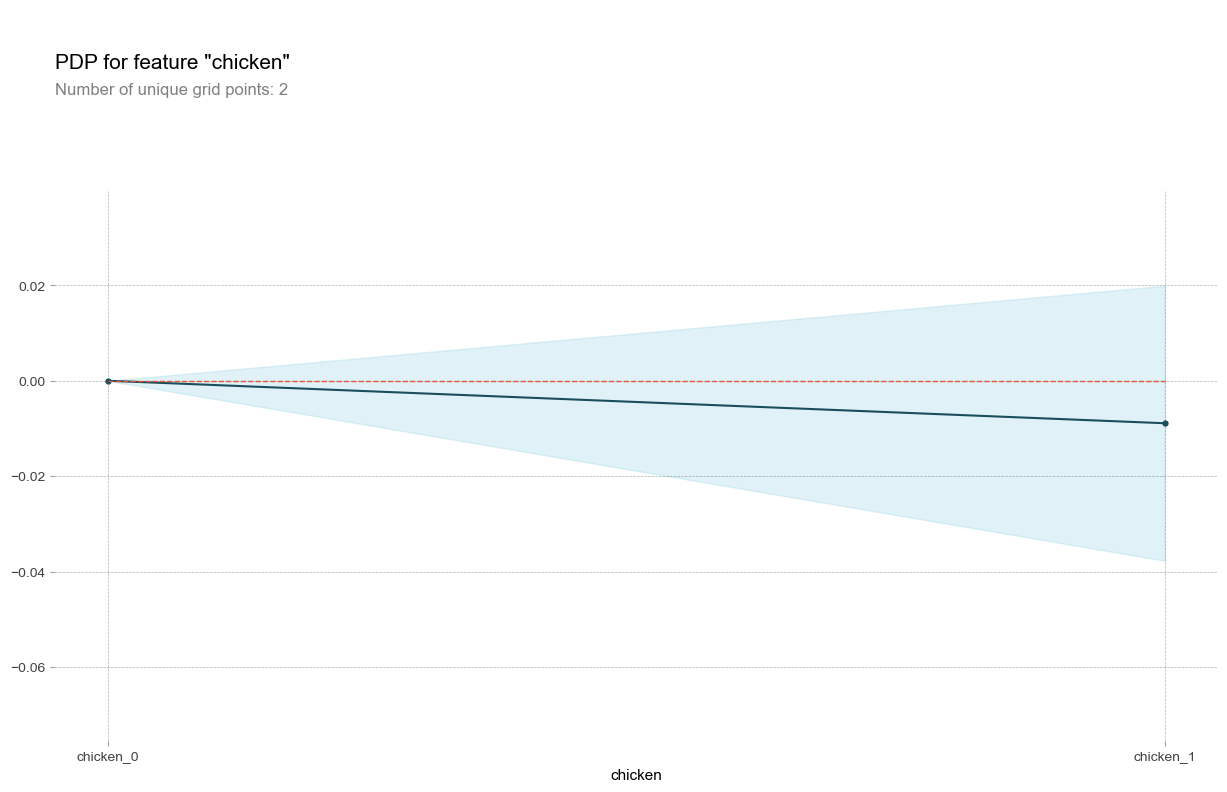

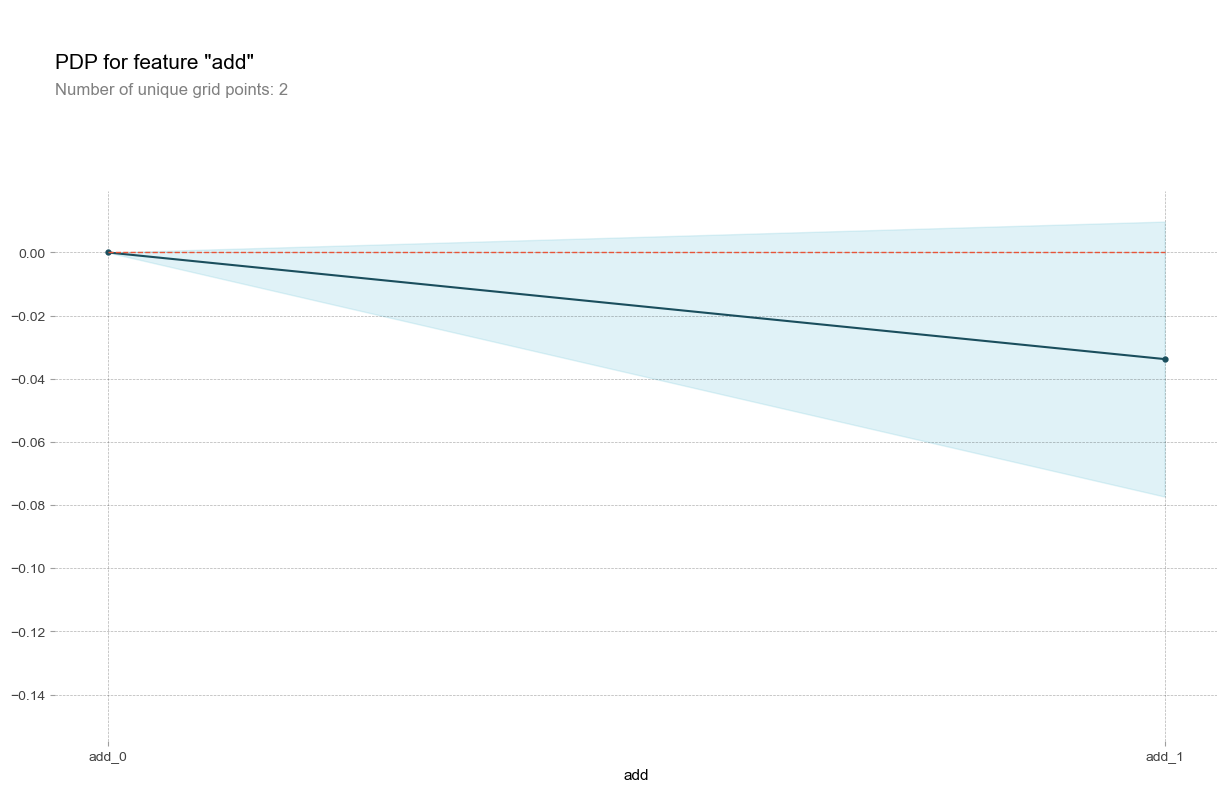

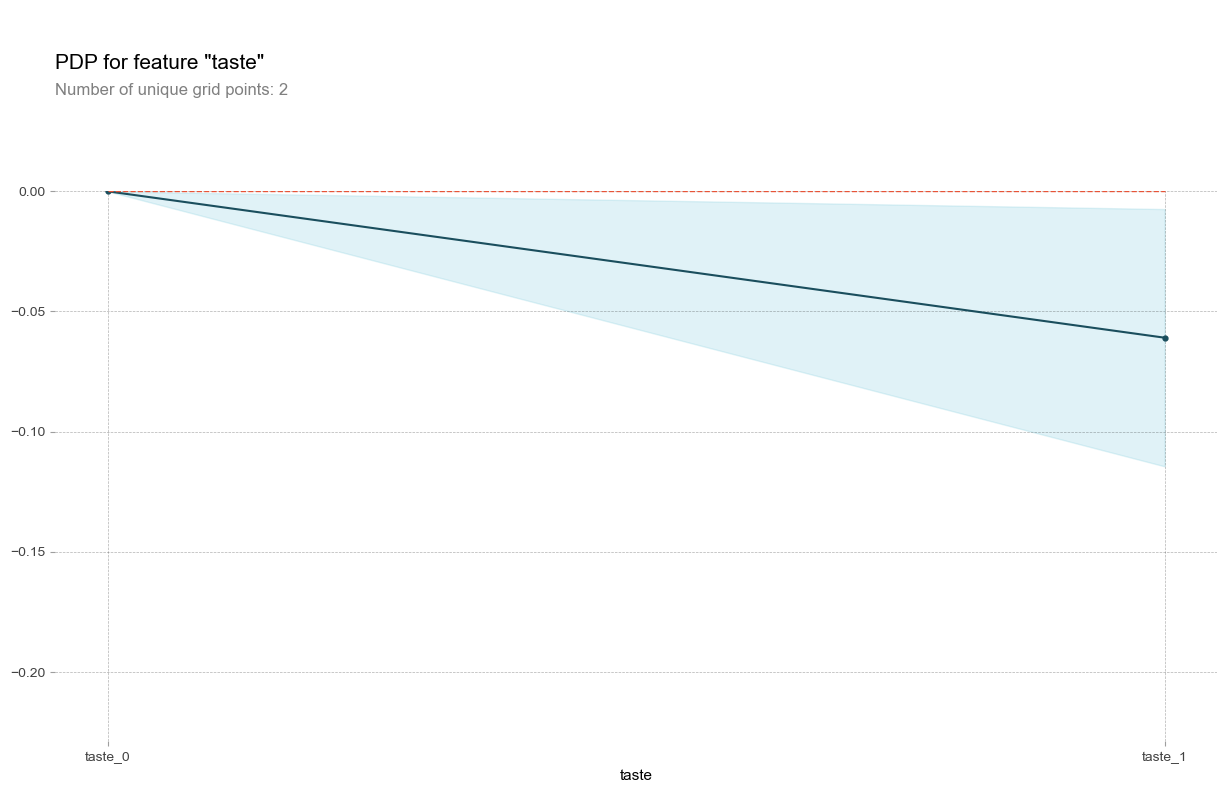

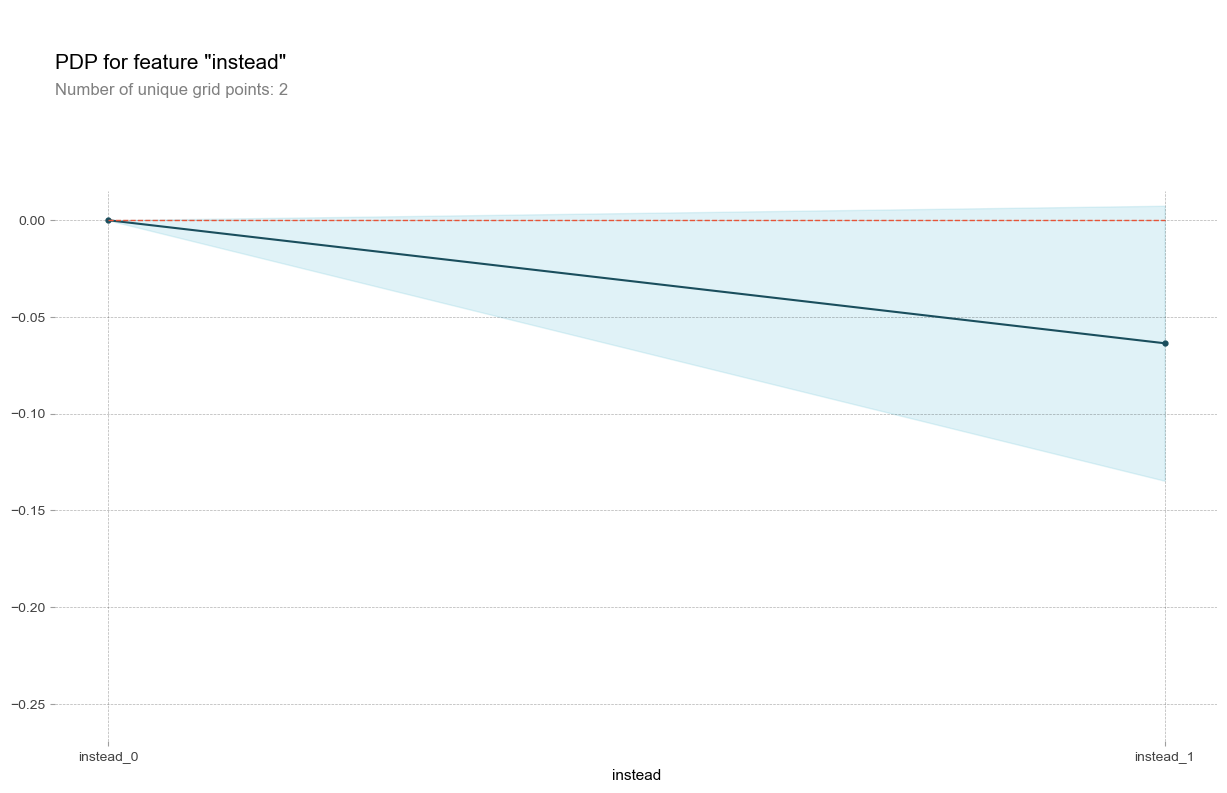

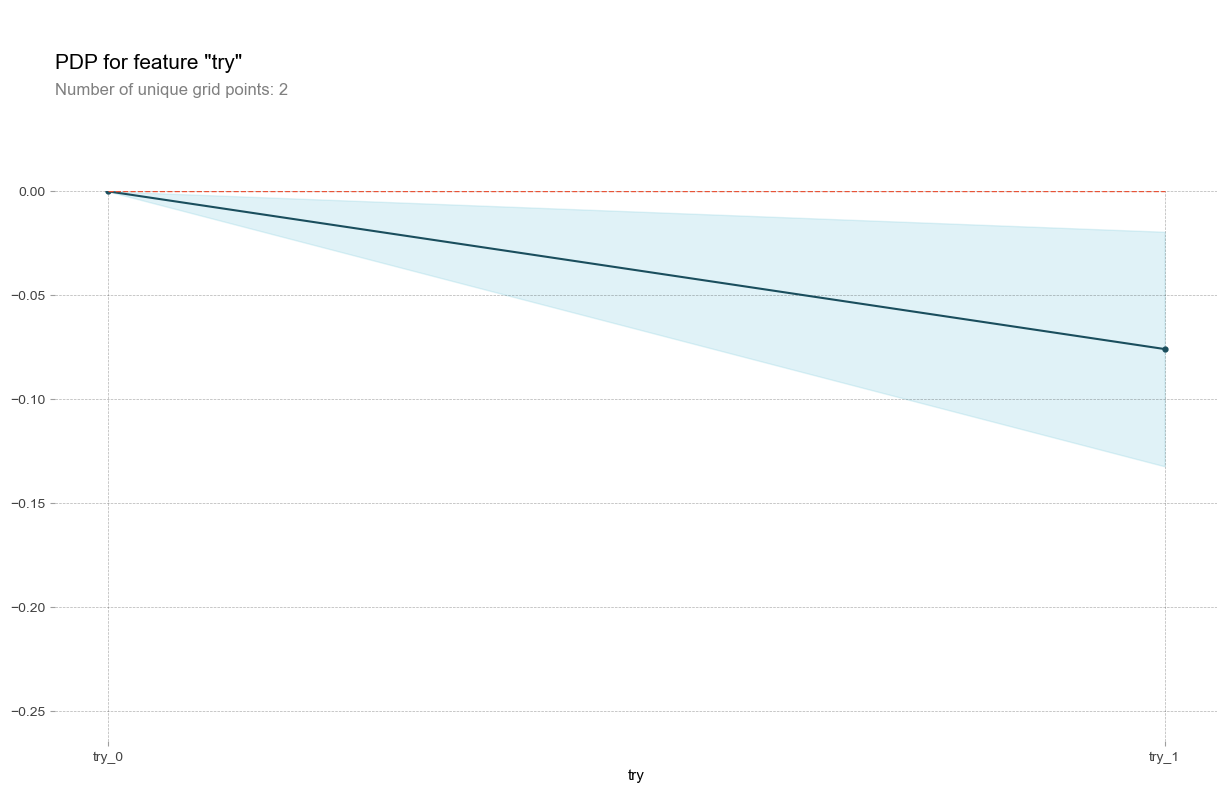

In [56]:
for i,pdp_feat in enumerate(l_pdp_rfr):
    pdp.pdp_plot(pdp_feat,X_test.columns[i])

For example, we see that increasing the preparation time and the number of steps in general leads to a more negative sentiment, while recipes with more ingredients generally receive more positive reviews.